In [128]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
import datetime 
import requests
import io
import re

# Data Processing

## Loading data

In [13]:
url = "https://data.covid.umd.edu/data/County.csv"
s = requests.get(url).content
df_social_mobility_org = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [68]:
# df_social_mobility_org.head()
# df_social_mobility_org.columns.values

In [41]:
cols = [c for c in df_social_mobility_org.columns if c.lower()[-4:] != 'rank']

In [42]:
len(cols)

43

In [44]:
cols_1 = [c for c in cols if c.lower()[0] == '%']

In [45]:
cols_2 = [c for c in cols if c.lower()[0] != '%']

In [63]:
cols_1_new = ['% staying home', '% change in consumption', 
              '% people older than 60', '% Male', '% hospital bed utilization']

In [64]:
cols_new = ['CTFIPS', 'CTNAME', 'STFIPS', 
              'Social distancing index','Trips/person', 'Miles/person', 
              'date', 'Median income', 'Population density', 
              'Employment density', 'Hospital beds/1000 people', 'COVID exposure/1000 people', 
              'Unemployment rate', 'COVID death rate', 'Active cases/1000 people', 
              'Testing capacity', 'Tests done/1000 people']


In [65]:
cols_new.extend(cols_1_new)

In [66]:
cols_new

['CTFIPS',
 'CTNAME',
 'STFIPS',
 'Social distancing index',
 'Trips/person',
 'Miles/person',
 'date',
 'Median income',
 'Population density',
 'Employment density',
 'Hospital beds/1000 people',
 'COVID exposure/1000 people',
 'Unemployment rate',
 'COVID death rate',
 'Active cases/1000 people',
 'Testing capacity',
 'Tests done/1000 people',
 '% staying home',
 '% change in consumption',
 '% people older than 60',
 '% Male',
 '% hospital bed utilization']

In [69]:
df_social_mobility_org = df_social_mobility_org[cols_new]

In [70]:
df_social_mobility_org.head()

,CTFIPS,CTNAME,STFIPS,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,...,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization
0,1001,Autauga County,1,54,2.25,24.7,01/01/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,27,-22.5,19,48.68,47.1
1,1001,Autauga County,1,25,2.83,37.6,01/02/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,18,-14.3,19,48.68,47.1
2,1001,Autauga County,1,15,3.18,40.3,01/03/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,15,-0.4,19,48.68,47.1
3,1001,Autauga County,1,33,2.85,29.5,01/04/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,20,-2.3,19,48.68,47.1
4,1001,Autauga County,1,40,2.56,30.9,01/05/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,22,-9.7,19,48.68,47.1


In [74]:
df_social_mobility_org['date'].unique()

array(['01/01/2020', '01/02/2020', '01/03/2020', '01/04/2020',
       '01/05/2020', '01/06/2020', '01/07/2020', '01/08/2020',
       '01/09/2020', '01/10/2020', '01/11/2020', '01/12/2020',
       '01/13/2020', '01/14/2020', '01/15/2020', '01/16/2020',
       '01/17/2020', '01/18/2020', '01/19/2020', '01/20/2020',
       '01/21/2020', '01/22/2020', '01/23/2020', '01/24/2020',
       '01/25/2020', '01/26/2020', '01/27/2020', '01/28/2020',
       '01/29/2020', '01/30/2020', '01/31/2020', '02/01/2020',
       '02/02/2020', '02/03/2020', '02/04/2020', '02/05/2020',
       '02/06/2020', '02/07/2020', '02/08/2020', '02/09/2020',
       '02/10/2020', '02/11/2020', '02/12/2020', '02/13/2020',
       '02/14/2020', '02/15/2020', '02/16/2020', '02/17/2020',
       '02/18/2020', '02/19/2020', '02/20/2020', '02/21/2020',
       '02/22/2020', '02/23/2020', '02/24/2020', '02/25/2020',
       '02/26/2020', '02/27/2020', '02/28/2020', '02/29/2020',
       '03/01/2020', '03/02/2020', '03/03/2020', '03/04

In [71]:
df_COVID19_org = pd.read_csv('/Users/junyiguo/Documents/GitHub/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')


In [72]:
df_COVID19_org.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,1218,1219,1235,1241,1240,1255,1264,1266,1286,1286
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,3877,3888,3906,3931,3957,3997,4037,4069,4083,4100
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,604,605,606,613,619,622,626,629,633,628
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,469,474,476,490,494,501,503,510,510,511
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,860,863,887,901,912,930,931,934,946,967


In [75]:
df_COVID19_org.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '8/16/20', '8/17/20', '8/18/20', '8/19/20', '8/20/20', '8/21/20',
       '8/22/20', '8/23/20', '8/24/20', '8/25/20'],
      dtype='object', length=228)

In [82]:
df_hospital_org = pd.read_csv('/Users/junyiguo/Documents/GitHub/Hospital_Resources/Definitive_Healthcare%3A_USA_Hospital_Beds.csv')
cols = ['COUNTY_NAME', 'STATE_NAME', 'NUM_LICENSED_BEDS', 'NUM_STAFFED_BEDS', 
        'NUM_ICU_BEDS', 'AVG_VENTILATOR_USAGE']
df_hospital_org = df_hospital_org[cols]

In [83]:
df_hospital_org.head()

,COUNTY_NAME,STATE_NAME,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
0,Maricopa,Arizona,62.0,62.0,0,0.0
1,Pima,Arizona,295.0,295.0,2,2.0
2,Fresno,California,54.0,54.0,2,2.0
3,New Haven,Connecticut,216.0,216.0,1,2.0
4,New Castle,Delaware,62.0,62.0,0,1.0


In [95]:
url = "https://data.covid.umd.edu/fips-states.csv"
s = requests.get(url).content
df_state_fips = pd.read_csv(io.StringIO(s.decode('utf-8')))
cols = ['state_name', 'fips']
df_state_fips = df_state_fips[cols]

In [88]:
# loading original hospital data
# df_hospital_org = pd.read_csv('/Users/junyiguo/Documents/GitHub/Hospital_Resources/Definitive_Healthcare%3A_USA_Hospital_Beds.csv', usecols = ['COUNTY_NAME', 'STATE_NAME', 'NUM_LICENSED_BEDS', 'NUM_STAFFED_BEDS', 'AVG_VENTILATOR_USAGE'])
# df_social_mobility_org = pd.read_csv('/Users/junyiguo/Documents/summer_project/social_mobility_data/County.csv', usecols = ['CTNAME', 'STFIPS', 'date', 'Social distancing index', 'New cases/1000 people', 'Population density', '% people older than 60', 'COVID death rate'])
# df_COVID19_org = pd.read_csv('/Users/junyiguo/Documents/GitHub/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
# df_state_fips = pd.read_csv('//Users/junyiguo/Documents/summer_project/social_mobility_data/fips-states.csv', usecols = ['state_name', 'fips'])


In [89]:
# Check the shape of the dataset
print(df_hospital_org.shape)
df_hospital_org.head()

(6622, 6)


,COUNTY_NAME,STATE_NAME,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
0,Maricopa,Arizona,62.0,62.0,0,0.0
1,Pima,Arizona,295.0,295.0,2,2.0
2,Fresno,California,54.0,54.0,2,2.0
3,New Haven,Connecticut,216.0,216.0,1,2.0
4,New Castle,Delaware,62.0,62.0,0,1.0


In [90]:
# Check the shape of the dataset
print(df_social_mobility_org.shape)
df_social_mobility_org.head()

(735228, 22)


,CTFIPS,CTNAME,STFIPS,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,...,Unemployment rate,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization
0,1001,Autauga County,1,54,2.25,24.7,01/01/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,27,-22.5,19,48.68,47.1
1,1001,Autauga County,1,25,2.83,37.6,01/02/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,18,-14.3,19,48.68,47.1
2,1001,Autauga County,1,15,3.18,40.3,01/03/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,15,-0.4,19,48.68,47.1
3,1001,Autauga County,1,33,2.85,29.5,01/04/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,20,-2.3,19,48.68,47.1
4,1001,Autauga County,1,40,2.56,30.9,01/05/2020,58786,91,19,...,2.7,0.0,0.0,0.0,0.0,22,-9.7,19,48.68,47.1


In [91]:
# Check the shape of the dataset
print(df_COVID19_org.shape)
df_COVID19_org.head()

(3340, 228)


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,1218,1219,1235,1241,1240,1255,1264,1266,1286,1286
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,3877,3888,3906,3931,3957,3997,4037,4069,4083,4100
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,604,605,606,613,619,622,626,629,633,628
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,469,474,476,490,494,501,503,510,510,511
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,860,863,887,901,912,930,931,934,946,967


In [96]:
# Check the shape of the dataset
print(df_state_fips.shape)
df_state_fips.head()

(51, 2)


,state_name,fips
0,Alabama,1
1,Alaska,2
2,Arizona,4
3,Arkansas,5
4,California,6


## Preprocess Hospital resources data

In [97]:
# Drop null values
print(df_hospital_org.isnull().sum())
df_hospital = df_hospital_org.dropna()

COUNTY_NAME              28
STATE_NAME               28
NUM_LICENSED_BEDS       150
NUM_STAFFED_BEDS        238
NUM_ICU_BEDS              0
AVG_VENTILATOR_USAGE     71
dtype: int64


In [98]:
# Combining the state name with the county name and
# group the dataset by county
print(df_hospital.dtypes)
print(df_hospital.describe())

df_hospital['COUNTY'] = df_hospital['COUNTY_NAME'] + str(',') + df_hospital["STATE_NAME"]
df_hospital_group = df_hospital.groupby(by = 'COUNTY').agg('sum').reset_index()

df_hospital_group.drop(df_hospital_group.loc[(df_hospital_group['NUM_STAFFED_BEDS']/ df_hospital_group['NUM_LICENSED_BEDS'] <= 0.1) 
                                             & (df_hospital_group['NUM_STAFFED_BEDS'] <= 10)].index, inplace = True)
print(len(df_hospital_group))
df_hospital_group.head()

COUNTY_NAME              object
STATE_NAME               object
NUM_LICENSED_BEDS       float64
NUM_STAFFED_BEDS        float64
NUM_ICU_BEDS              int64
AVG_VENTILATOR_USAGE    float64
dtype: object
       NUM_LICENSED_BEDS  NUM_STAFFED_BEDS  NUM_ICU_BEDS  AVG_VENTILATOR_USAGE
count        6356.000000       6356.000000   6356.000000           6356.000000
mean          150.487256        128.924638     14.021554              3.650409
std           183.131072        160.582287     22.457457              5.517830
min             1.000000          1.000000      0.000000              0.000000
25%            26.000000         25.000000      3.000000              0.000000
50%            79.000000         66.000000      6.000000              2.000000
75%           200.000000        168.000000     16.000000              4.000000
max          2059.000000       2753.000000    310.000000             61.000000
2491


,COUNTY,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,AVG_VENTILATOR_USAGE
0,"Abbeville,South Carolina",25.0,25.0,6,2.0
1,"Acadia,Louisiana",170.0,144.0,7,3.0
2,"Accomack,Virginia",52.0,46.0,10,3.0
3,"Ada,Idaho",1311.0,1240.0,97,24.0
4,"Adair,Iowa",25.0,25.0,4,0.0


## Preprocess social mobility data

In [99]:
# Drop null values
print(df_social_mobility_org.isnull().sum())
df_social_mobility = df_social_mobility_org.dropna()

CTFIPS                        0
CTNAME                        0
STFIPS                        0
Social distancing index       0
Trips/person                  0
Miles/person                  0
date                          0
Median income                 0
Population density            0
Employment density            0
Hospital beds/1000 people     0
COVID exposure/1000 people    0
Unemployment rate             0
COVID death rate              0
Active cases/1000 people      0
Testing capacity              0
Tests done/1000 people        0
% staying home                0
% change in consumption       0
% people older than 60        0
% Male                        0
% hospital bed utilization    0
dtype: int64


In [100]:
# Modify county names to match names in the other dataset
df_social_mobility['CTNAME'] = df_social_mobility['CTNAME'].apply(lambda x: x.replace(str(' County'), ''))
df_social_mobility_merge = pd.merge(df_social_mobility, df_state_fips, left_on = 'STFIPS', right_on = 'fips')
df_social_mobility_merge['COUNTY'] = df_social_mobility_merge['CTNAME'] + str(',') + df_social_mobility_merge['state_name']
df_social_mobility_merge.drop(columns = ['CTNAME', 'STFIPS', 'state_name', 'fips'], inplace = True)
df_social_mobility_merge.head()
#df_social_mobility_group = df_social_mobility_merge.groupby(by = 'date')

#print(df_social_mobility_group.size())
#df_social_mobility_current = df_social_mobility_group.get_group('06/22/2020')

# print(df_social_mobility_current.dtypes)
# print(df_social_mobility_current.describe())
# df_social_mobility_current.head()
#df_social_mobility_current['Population density'].plot.hist()

#df_social_mobility_current.loc[df_social_mobility_current['Population density'] == 0]
#len(df_social_mobility_group.get_group('01/01/2020')['COUNTY'].unique())

,CTFIPS,Social distancing index,Trips/person,Miles/person,date,Median income,Population density,Employment density,Hospital beds/1000 people,COVID exposure/1000 people,...,COVID death rate,Active cases/1000 people,Testing capacity,Tests done/1000 people,% staying home,% change in consumption,% people older than 60,% Male,% hospital bed utilization,COUNTY
0,1001,54,2.25,24.7,01/01/2020,58786,91,19,3.79,0.0,...,0.0,0.0,0.0,0.0,27,-22.5,19,48.68,47.1,"Autauga,Alabama"
1,1001,25,2.83,37.6,01/02/2020,58786,91,19,3.79,0.0,...,0.0,0.0,0.0,0.0,18,-14.3,19,48.68,47.1,"Autauga,Alabama"
2,1001,15,3.18,40.3,01/03/2020,58786,91,19,3.79,0.0,...,0.0,0.0,0.0,0.0,15,-0.4,19,48.68,47.1,"Autauga,Alabama"
3,1001,33,2.85,29.5,01/04/2020,58786,91,19,3.79,0.0,...,0.0,0.0,0.0,0.0,20,-2.3,19,48.68,47.1,"Autauga,Alabama"
4,1001,40,2.56,30.9,01/05/2020,58786,91,19,3.79,0.0,...,0.0,0.0,0.0,0.0,22,-9.7,19,48.68,47.1,"Autauga,Alabama"


## Preprocess COVID19 data

In [101]:
# Drop null values
print(df_COVID19_org.isnull().sum())
df_COVID19 = df_COVID19_org.dropna()
print(df_COVID19.shape)

UID         0
iso2        0
iso3        0
code3       0
FIPS       10
           ..
8/21/20     0
8/22/20     0
8/23/20     0
8/24/20     0
8/25/20     0
Length: 228, dtype: int64
(3324, 228)


In [102]:
#df_COVID19.columns.to_series()

In [103]:
# Generate demographic information
df_COVID19_demo = df_COVID19[['Admin2', 'Province_State', 'Lat', 'Long_']]
df_COVID19_demo['COUNTY'] = df_COVID19_demo['Admin2'] + str(',') + df_COVID19_demo['Province_State']
df_COVID19_demo.drop(columns = ['Admin2', 'Province_State'], inplace = True)
df_COVID19_demo.head()

,Lat,Long_,COUNTY
0,32.539527,-86.644082,"Autauga,Alabama"
1,30.727750,-87.722071,"Baldwin,Alabama"
2,31.868263,-85.387129,"Barbour,Alabama"
3,32.996421,-87.125115,"Bibb,Alabama"
4,33.982109,-86.567906,"Blount,Alabama"


#### Find common time section for both COVID19 and social mobility dataset

In [156]:
date_COVID19 = df_COVID19.columns.values
date_SMD = df_social_mobility['date'].unique()

In [157]:
print(date_COVID19)
print(date_SMD)

['UID' 'iso2' 'iso3' 'code3' 'FIPS' 'Admin2' 'Province_State'
 'Country_Region' 'Lat' 'Long_' 'Combined_Key' '1/22/20' '1/23/20'
 '1/24/20' '1/25/20' '1/26/20' '1/27/20' '1/28/20' '1/29/20' '1/30/20'
 '1/31/20' '2/1/20' '2/2/20' '2/3/20' '2/4/20' '2/5/20' '2/6/20' '2/7/20'
 '2/8/20' '2/9/20' '2/10/20' '2/11/20' '2/12/20' '2/13/20' '2/14/20'
 '2/15/20' '2/16/20' '2/17/20' '2/18/20' '2/19/20' '2/20/20' '2/21/20'
 '2/22/20' '2/23/20' '2/24/20' '2/25/20' '2/26/20' '2/27/20' '2/28/20'
 '2/29/20' '3/1/20' '3/2/20' '3/3/20' '3/4/20' '3/5/20' '3/6/20' '3/7/20'
 '3/8/20' '3/9/20' '3/10/20' '3/11/20' '3/12/20' '3/13/20' '3/14/20'
 '3/15/20' '3/16/20' '3/17/20' '3/18/20' '3/19/20' '3/20/20' '3/21/20'
 '3/22/20' '3/23/20' '3/24/20' '3/25/20' '3/26/20' '3/27/20' '3/28/20'
 '3/29/20' '3/30/20' '3/31/20' '4/1/20' '4/2/20' '4/3/20' '4/4/20'
 '4/5/20' '4/6/20' '4/7/20' '4/8/20' '4/9/20' '4/10/20' '4/11/20'
 '4/12/20' '4/13/20' '4/14/20' '4/15/20' '4/16/20' '4/17/20' '4/18/20'
 '4/19/20' '4/20/20' '4/21

In [165]:
# Obtain all date information in the input array

def get_start_and_end(dates):
    date_list = []
    for date in dates:
        try:
            #print(date)
            if re.match('^[0-9]{1}[/][0-9]{2}/[0-9]{2}$', date):
                date  = date + '20'
            date_t = datetime.datetime.strptime(date,"%m/%d/%Y")
            date_list.append(date_t)
        except ValueError:
            if re.match('^[0-9]{1}[/][0-9]{2}/[0-9]{2}$', date):
                print('Date not converted to datetime properly!')
                print(date)
                return
            continue
    start = min(date_list)
    end = max(date_list)
#     start_date = datetime.datetime(2020, 3, 1)
#     end_date = datetime.datetime(2020, 6, 26)
#     print(min(date_list))
#     print(max(date_list))
    return start, end

In [168]:
start_COVID19, end_COVID19 = get_start_and_end(date_COVID19)
start_SMD, end_SMD = get_start_and_end(date_SMD)
start_date = max(start_COVID19, start_SMD)
end_date = min(end_COVID19, end_SMD)
print(start_date, end_date)

2020-01-22 00:00:00 2020-08-21 00:00:00


In [169]:
# import re
# if re.match('^[0-9]{1}[/][0-9]{2}/[0-9]{2}$', '9/29/20'):
#     print('True values')

In [170]:
# daily_part
# this function partition data segments between the input start date and end date 
# specifically targetting COVID19 dataframe
# input: df: target dataframe, start: start date, end: end date
# return: the partitioned dataframe
def daily_part(df, start, end):
    start_idx = df.columns.get_loc(start)
    end_idx = df.columns.get_loc(end)
    
    df_daily = df.iloc[:, start_idx: end_idx + 1]
    return df_daily

In [179]:
# Partition cumulative positive test number between 
start = start_date.strftime("%m/%d/%Y")[1:-2]
end = end_date.strftime("%m/%d/%Y")[1:-2]
print(start, end)
df_COVID19_daily = daily_part(df_COVID19, start, end)
df_COVID19_daily.head()

1/22/20 8/21/20


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20
0,0,0,0,0,0,0,0,0,0,0,...,1188,1196,1196,1206,1218,1219,1235,1241,1240,1255
1,0,0,0,0,0,0,0,0,0,0,...,3710,3744,3791,3839,3877,3888,3906,3931,3957,3997
2,0,0,0,0,0,0,0,0,0,0,...,581,586,590,598,604,605,606,613,619,622
3,0,0,0,0,0,0,0,0,0,0,...,453,457,465,469,469,474,476,490,494,501
4,0,0,0,0,0,0,0,0,0,0,...,825,835,848,854,860,863,887,901,912,930


In [180]:
# Combining the demograohic information with the numerical data for COVID19 dataset
df_COVID19 = pd.concat([df_COVID19_demo, df_COVID19_daily], axis = 1)
df_COVID19.head()

,Lat,Long_,COUNTY,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20
0,32.539527,-86.644082,"Autauga,Alabama",0,0,0,0,0,0,0,...,1188,1196,1196,1206,1218,1219,1235,1241,1240,1255
1,30.727750,-87.722071,"Baldwin,Alabama",0,0,0,0,0,0,0,...,3710,3744,3791,3839,3877,3888,3906,3931,3957,3997
2,31.868263,-85.387129,"Barbour,Alabama",0,0,0,0,0,0,0,...,581,586,590,598,604,605,606,613,619,622
3,32.996421,-87.125115,"Bibb,Alabama",0,0,0,0,0,0,0,...,453,457,465,469,469,474,476,490,494,501
4,33.982109,-86.567906,"Blount,Alabama",0,0,0,0,0,0,0,...,825,835,848,854,860,863,887,901,912,930


In [181]:
# Drop unassigned cases and out of state cases for each state
df_COVID19.drop(index = df_COVID19[df_COVID19['COUNTY'].str.contains('Unassigned')].index, inplace = True)
df_COVID19.drop(index = df_COVID19[df_COVID19['COUNTY'].str.contains('Out of')].index, inplace = True)

In [182]:
df_COVID19

,Lat,Long_,COUNTY,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20
0,32.539527,-86.644082,"Autauga,Alabama",0,0,0,0,0,0,0,...,1188,1196,1196,1206,1218,1219,1235,1241,1240,1255
1,30.727750,-87.722071,"Baldwin,Alabama",0,0,0,0,0,0,0,...,3710,3744,3791,3839,3877,3888,3906,3931,3957,3997
2,31.868263,-85.387129,"Barbour,Alabama",0,0,0,0,0,0,0,...,581,586,590,598,604,605,606,613,619,622
3,32.996421,-87.125115,"Bibb,Alabama",0,0,0,0,0,0,0,...,453,457,465,469,469,474,476,490,494,501
4,33.982109,-86.567906,"Blount,Alabama",0,0,0,0,0,0,0,...,825,835,848,854,860,863,887,901,912,930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,41.659439,-108.882788,"Sweetwater,Wyoming",0,0,0,0,0,0,0,...,266,267,271,275,276,278,279,285,285,288
3335,43.935225,-110.589080,"Teton,Wyoming",0,0,0,0,0,0,0,...,373,375,383,385,389,390,393,394,398,399
3336,41.287818,-110.547578,"Uinta,Wyoming",0,0,0,0,0,0,0,...,278,278,277,276,276,277,278,283,283,283
3338,43.904516,-107.680187,"Washakie,Wyoming",0,0,0,0,0,0,0,...,82,86,96,97,97,100,102,104,106,106


## Get 5 nearby county

In [183]:
df_COVID19.head()

,Lat,Long_,COUNTY,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20
0,32.539527,-86.644082,"Autauga,Alabama",0,0,0,0,0,0,0,...,1188,1196,1196,1206,1218,1219,1235,1241,1240,1255
1,30.727750,-87.722071,"Baldwin,Alabama",0,0,0,0,0,0,0,...,3710,3744,3791,3839,3877,3888,3906,3931,3957,3997
2,31.868263,-85.387129,"Barbour,Alabama",0,0,0,0,0,0,0,...,581,586,590,598,604,605,606,613,619,622
3,32.996421,-87.125115,"Bibb,Alabama",0,0,0,0,0,0,0,...,453,457,465,469,469,474,476,490,494,501
4,33.982109,-86.567906,"Blount,Alabama",0,0,0,0,0,0,0,...,825,835,848,854,860,863,887,901,912,930


In [184]:
# Create dataframe with only demograohic imformation
df_county = df_COVID19[['COUNTY', 'Lat', 'Long_']]

In [186]:
# np.radians(df_county['Lat'].values)

In [187]:
def dist_from_coordinates(lat_list, lon_list, lat_cur, lon_cur):
    """
        dist_from_coordinates
        Get the distance between two coordinate using haversine formula
        input: lat_list: list of latitude
               lon_list: list of longitude
               lat_cur: current point latitude
               lon_cur: current point longitude
        return: array of distance
    """
    # Earth radius in km
    R = 6371

    #conversion to radians
    d_lat = np.radians(lat_list-lat_cur)
    d_lon = np.radians(lon_list-lon_cur)

    r_lat_list = np.radians(lat_list)
    r_lat_cur = np.radians(lat_cur)

    #haversine formula
    a = np.sin(d_lat/2.) **2 + np.cos(r_lat_list) * np.cos(r_lat_cur) * np.sin(d_lon/2.)**2

    haversine = 2 * R * np.arcsin(np.sqrt(a))

    return haversine

In [229]:
def get_NearbyCounty(df, row):
    """
        get_NearbyCounty
        This function find the nearby county by rank for the current row using the haversine formula 
        and the coordinate for each county
        input: df: the geographic dataframe; row: row index
        return: list countaining 5 nearby counties' name
    """
    # df['Distance'] = np.sqrt((df['Lat'] - row['Lat'])**2 + (df['Long_'] - row['Long_'])**2)
    df['Distance'] = dist_from_coordinates(df['Lat'], df['Long_'], row['Lat'], row['Long_'])
    df.sort_values(by = ['Distance'], inplace = True)
    # county_array = np.array(df['COUNTY'].iloc[1:6].values)
    county_array = np.array(df['COUNTY'].iloc[1:6].values)
    # print(county_array)
    return county_array

In [231]:
# Generate nearby county
# type(df_county.apply(lambda x: get_NearbyCounty(df_county.copy(), x), axis = 1))
df_county['NEARBY_COUNTY_total'] = df_county.apply(lambda x: get_NearbyCounty(df_county.copy(), x), axis = 1)
# df = pd.DataFrame(df_county.NEARBY_COUNTY_total.tolist(), index= df_county.index)
# for i in range(len(df[0])):
#     if len(df[0].iloc[i]) != 5:
#         print(i)
df_county[['1st_NEARBY_COUNTY', '2nd_NEARBY_COUNTY', '3rd_NEARBY_COUNTY', '4th_NEARBY_COUNTY', '5th_NEARBY_COUNTY']] = pd.DataFrame(df_county['NEARBY_COUNTY_total'].to_list(), index= df_county.index)
# df
# df_county['NEARBY_COUNTY_total'][0]
df_county.head()

,COUNTY,Lat,Long_,NEARBY_COUNTY_total,1st_NEARBY_COUNTY,2nd_NEARBY_COUNTY,3rd_NEARBY_COUNTY,4th_NEARBY_COUNTY,5th_NEARBY_COUNTY
0,"Autauga,Alabama",32.539527,-86.644082,"[Chilton,Alabama, Lowndes,Alabama, Elmore,Alab...","Chilton,Alabama","Lowndes,Alabama","Elmore,Alabama","Dallas,Alabama","Montgomery,Alabama"
1,"Baldwin,Alabama",30.727750,-87.722071,"[Escambia,Florida, Mobile,Alabama, Santa Rosa,...","Escambia,Florida","Mobile,Alabama","Santa Rosa,Florida","Escambia,Alabama","Washington,Alabama"
2,"Barbour,Alabama",31.868263,-85.387129,"[Quitman,Georgia, Bullock,Alabama, Henry,Alaba...","Quitman,Georgia","Bullock,Alabama","Henry,Alabama","Clay,Georgia","Russell,Alabama"
3,"Bibb,Alabama",32.996421,-87.125115,"[Chilton,Alabama, Perry,Alabama, Tuscaloosa,Al...","Chilton,Alabama","Perry,Alabama","Tuscaloosa,Alabama","Shelby,Alabama","Hale,Alabama"
4,"Blount,Alabama",33.982109,-86.567906,"[Cullman,Alabama, St. Clair,Alabama, Etowah,Al...","Cullman,Alabama","St. Clair,Alabama","Etowah,Alabama","Marshall,Alabama","Jefferson,Alabama"


In [232]:
df_county.shape

(3220, 9)

In [233]:
# Drop latitude abd longitude columns
df_county.drop(columns = ['Lat', 'Long_', 'NEARBY_COUNTY_total'], inplace = True)
df_county.head()

,COUNTY,1st_NEARBY_COUNTY,2nd_NEARBY_COUNTY,3rd_NEARBY_COUNTY,4th_NEARBY_COUNTY,5th_NEARBY_COUNTY
0,"Autauga,Alabama","Chilton,Alabama","Lowndes,Alabama","Elmore,Alabama","Dallas,Alabama","Montgomery,Alabama"
1,"Baldwin,Alabama","Escambia,Florida","Mobile,Alabama","Santa Rosa,Florida","Escambia,Alabama","Washington,Alabama"
2,"Barbour,Alabama","Quitman,Georgia","Bullock,Alabama","Henry,Alabama","Clay,Georgia","Russell,Alabama"
3,"Bibb,Alabama","Chilton,Alabama","Perry,Alabama","Tuscaloosa,Alabama","Shelby,Alabama","Hale,Alabama"
4,"Blount,Alabama","Cullman,Alabama","St. Clair,Alabama","Etowah,Alabama","Marshall,Alabama","Jefferson,Alabama"


In [235]:
# Convert the dataframe to dictionary
dict_1st_nearby = df_county.set_index('COUNTY')['1st_NEARBY_COUNTY'].to_dict()
dict_2nd_nearby = df_county.set_index('COUNTY')['2nd_NEARBY_COUNTY'].to_dict()
dict_3rd_nearby = df_county.set_index('COUNTY')['3rd_NEARBY_COUNTY'].to_dict()
dict_4th_nearby = df_county.set_index('COUNTY')['4th_NEARBY_COUNTY'].to_dict()
dict_5th_nearby = df_county.set_index('COUNTY')['5th_NEARBY_COUNTY'].to_dict()
#len(dict_NearbyCounty['Autauga,Alabama'][0])

In [45]:
#df_sub.iloc[0]['COUNTY'] in df_sub["NEARBY_COUNTY"].iloc[3][0]

## Altering structure for COVID19 dataset

In [46]:
# Create date array
date_array = np.array(df_COVID19_daily.columns)
datetime_array = [datetime.datetime.strptime(date + '20',"%m/%d/%Y") for date in date_array]
datetime_list = [datetime.strftime("%m/%d/%Y") for datetime in datetime_array]
datetime_list = datetime_list[1:]

In [119]:
# Drop unnecessary columns and reset index
df_COVID19_tempo = df_COVID19.drop(columns = ['Lat', 'Long_'])
df_COVID19_tempo.set_index('COUNTY', inplace = True)

In [120]:
df_copy = df_COVID19_tempo.copy()
for i in range(len(df_COVID19_tempo.columns) - 1):
    df_COVID19_tempo.iloc[:, i + 1] = df_copy.iloc[:, i + 1] - df_copy.iloc[:, i]
df_COVID19_tempo = df_COVID19_tempo.iloc[:, 1:]

In [121]:
df_COVID19_tempo.head()

,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,...,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20
COUNTY,,,,,,,,,,,,,,,,,,,,,
"Autauga,Alabama",0,0,0,0,0,0,0,0,0,0,...,2,25,11,20,3,8,11,16,10,9
"Baldwin,Alabama",0,0,0,0,0,0,0,0,0,0,...,3,9,12,7,10,7,13,14,13,38
"Barbour,Alabama",0,0,0,0,0,0,0,0,0,0,...,6,12,3,6,0,5,3,8,16,6
"Bibb,Alabama",0,0,0,0,0,0,0,0,0,0,...,2,3,5,0,1,2,6,6,8,4
"Blount,Alabama",0,0,0,0,0,0,0,0,0,0,...,2,6,9,4,6,4,6,9,8,8


In [122]:
#[(df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index[i], df_COVID19_tempo.columns.get_loc(col)) for col in df_COVID19_tempo.columns for i in range(len(df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index))]
#len(set([df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index[i] for col in df_COVID19_tempo.columns for i in range(len(df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index))]))

"""
Only include California Data for testing
Delete after testing
"""
decrease_list = list(set([df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index[i] 
                          for col in df_COVID19_tempo.columns for i in range(len(df_COVID19_tempo[col][df_COVID19_tempo[col] < 0].index))]))
CA_decrease_county = []
for county in decrease_list:
    if 'California' in county:
        CA_decrease_county.append(county)
        
len(CA_decrease_county)


22

In [123]:
"""
Only include California Data for testing
Delete after testing
"""

df_COVID19_tempo = df_COVID19_tempo.reset_index()
df_COVID19_tempo = df_COVID19_tempo.loc[df_COVID19_tempo['COUNTY'].str.contains('California')]
df_COVID19_tempo = df_COVID19_tempo.reset_index()
index_drop = [i for i in df_COVID19_tempo.index.array if df_COVID19_tempo.iloc[i]['COUNTY'] in CA_decrease_county]
df_COVID19_tempo = df_COVID19_tempo.drop(index = index_drop)
df_COVID19_tempo.set_index('COUNTY', inplace = True)

In [129]:
df_COVID19_tempo.drop(columns = ['index'], inplace = True)

In [130]:
stack_array = df_COVID19_tempo.stack().values.tolist()
len(stack_array)

4248

In [131]:
stack_array

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 3,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 4,
 1,
 3,
 0,
 0,
 0,
 6,
 0,
 0,
 4,
 0,
 0,
 7,
 0,
 4,
 5,
 5,
 0,
 0,
 3,
 3,
 2,
 0,
 1,
 0,
 0,
 8,
 6,
 2,
 0,
 4,
 0,
 0,
 17,
 8,
 8,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 0,
 2,
 4,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

In [132]:
county_array = np.array([])

In [133]:
#county_array = np.append(county_array, [np.repeat(county, len(date_array)) for county in df_COVID19_tempo.index])

In [134]:
county_array = np.repeat(df_COVID19_tempo.index, len(datetime_list)).tolist()

In [135]:
len(county_array)

4248

In [136]:
#cum_date_array = date_array.tolist()
cum_date_array = datetime_list * len(df_COVID19_tempo.index)

In [137]:
len(cum_date_array)

4248

In [138]:
len(stack_array)

4248

In [139]:
df_COVID19_final = pd.DataFrame({'COUNTY': county_array, 'DATE': cum_date_array, 'DAILY_INCREASE': stack_array})

In [140]:
df_COVID19_final['COUNTY_AND_DATE'] = df_COVID19_final['COUNTY'] + str(',') + df_COVID19_final['DATE']

In [141]:
df_COVID19_final[(df_COVID19_final['COUNTY'] == 'Autauga,Alabama') & (df_COVID19_final['DATE'] == '06/17/2020')]

,COUNTY,DATE,DAILY_INCREASE,COUNTY_AND_DATE


In [142]:
df_COVID19_final.head()

,COUNTY,DATE,DAILY_INCREASE,COUNTY_AND_DATE
0,"Butte,California",03/01/2020,0,"Butte,California,03/01/2020"
1,"Butte,California",03/02/2020,0,"Butte,California,03/02/2020"
2,"Butte,California",03/03/2020,0,"Butte,California,03/03/2020"
3,"Butte,California",03/04/2020,0,"Butte,California,03/04/2020"
4,"Butte,California",03/05/2020,0,"Butte,California,03/05/2020"


## Minor change in Social Mobility Dataset

In [143]:
df_social_mobility_merge.head()

,Social distancing index,date,% people older than 60,Population density,COVID death rate,New cases/1000 people,COUNTY
0,54,01/01/2020,19,91,0.0,0.0,"Autauga,Alabama"
1,25,01/02/2020,19,91,0.0,0.0,"Autauga,Alabama"
2,15,01/03/2020,19,91,0.0,0.0,"Autauga,Alabama"
3,33,01/04/2020,19,91,0.0,0.0,"Autauga,Alabama"
4,40,01/05/2020,19,91,0.0,0.0,"Autauga,Alabama"


In [144]:
df_social_mobility_merge[(df_social_mobility_merge['COUNTY'] == 'Autauga,Alabama') & (df_social_mobility_merge['date'] == '06/17/2020')]

,Social distancing index,date,% people older than 60,Population density,COVID death rate,New cases/1000 people,COUNTY
11058,22,06/17/2020,19,91,1.25,0.0719,"Autauga,Alabama"


In [145]:
len(df_social_mobility_merge)

559276

In [146]:
df_social_mobility_merge['date'] = [datetime.datetime.strptime(date,"%m/%d/%Y") for date in df_social_mobility_merge['date']]

In [147]:
start_date = datetime.datetime(2020, 3, 1)
end_date = datetime.datetime(2020, 6, 26)

In [148]:
df_social_mobility_part = df_social_mobility_merge[(df_social_mobility_merge['date'] >= start_date) 
                                                   & (df_social_mobility_merge['date'] <= end_date)]

In [149]:
df_social_mobility_part.head()

,Social distancing index,date,% people older than 60,Population density,COVID death rate,New cases/1000 people,COUNTY
60,35,2020-03-01,19,91,0.0,0.0,"Autauga,Alabama"
61,11,2020-03-02,19,91,0.0,0.0,"Autauga,Alabama"
62,10,2020-03-03,19,91,0.0,0.0,"Autauga,Alabama"
63,19,2020-03-04,19,91,0.0,0.0,"Autauga,Alabama"
64,12,2020-03-05,19,91,0.0,0.0,"Autauga,Alabama"


In [150]:
df_social_mobility_part['date'] = [datetime.strftime("%m/%d/%Y") for datetime in df_social_mobility_part['date']]

<ipython-input-150-b3a7b43c100f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_social_mobility_part['date'] = [datetime.strftime("%m/%d/%Y") for datetime in df_social_mobility_part['date']]


In [151]:
df_social_mobility_part.head()

,Social distancing index,date,% people older than 60,Population density,COVID death rate,New cases/1000 people,COUNTY
60,35,03/01/2020,19,91,0.0,0.0,"Autauga,Alabama"
61,11,03/02/2020,19,91,0.0,0.0,"Autauga,Alabama"
62,10,03/03/2020,19,91,0.0,0.0,"Autauga,Alabama"
63,19,03/04/2020,19,91,0.0,0.0,"Autauga,Alabama"
64,12,03/05/2020,19,91,0.0,0.0,"Autauga,Alabama"


In [152]:
df_social_mobility_part['COUNTY_AND_DATE'] = df_social_mobility_part['COUNTY'] + str(',') + df_social_mobility_part['date']
df_social_mobility_part.head()

<ipython-input-152-8e07899efa1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_social_mobility_part['COUNTY_AND_DATE'] = df_social_mobility_part['COUNTY'] + str(',') + df_social_mobility_part['date']


,Social distancing index,date,% people older than 60,Population density,COVID death rate,New cases/1000 people,COUNTY,COUNTY_AND_DATE
60,35,03/01/2020,19,91,0.0,0.0,"Autauga,Alabama","Autauga,Alabama,03/01/2020"
61,11,03/02/2020,19,91,0.0,0.0,"Autauga,Alabama","Autauga,Alabama,03/02/2020"
62,10,03/03/2020,19,91,0.0,0.0,"Autauga,Alabama","Autauga,Alabama,03/03/2020"
63,19,03/04/2020,19,91,0.0,0.0,"Autauga,Alabama","Autauga,Alabama,03/04/2020"
64,12,03/05/2020,19,91,0.0,0.0,"Autauga,Alabama","Autauga,Alabama,03/05/2020"


In [153]:
df_social_mobility_part.shape

(370756, 8)

## Combining social mobility datasets and COVID19 dataset

In [154]:
df_mobility_COVID19 = pd.merge(df_COVID19_final, df_social_mobility_part, on = ['COUNTY_AND_DATE'])

In [155]:
df_mobility_COVID19_new = df_mobility_COVID19.drop(columns = ['date', 'COUNTY_y'])

In [156]:
df_mobility_COVID19_new.head()

,COUNTY_x,DATE,DAILY_INCREASE,COUNTY_AND_DATE,Social distancing index,% people older than 60,Population density,COVID death rate,New cases/1000 people
0,"Butte,California",03/01/2020,0,"Butte,California,03/01/2020",38,24,135,0.00,0.0
1,"Butte,California",03/02/2020,0,"Butte,California,03/02/2020",18,24,135,0.00,0.0
2,"Butte,California",03/03/2020,0,"Butte,California,03/03/2020",15,24,135,0.00,0.0
3,"Butte,California",03/04/2020,0,"Butte,California,03/04/2020",17,24,135,0.03,0.0
4,"Butte,California",03/05/2020,0,"Butte,California,03/05/2020",17,24,135,0.03,0.0


In [157]:
df_mobility_COVID19_new = df_mobility_COVID19_new.rename(columns = {'COUNTY_x': 'COUNTY', 
                                                                    'DAILY_INCREASE': 'Daily increase'})

In [158]:
#df_mobility_COVID19_new[df_mobility_COVID19_new.isnull().any(axis=1)]

In [159]:
df_mobility_COVID19_new = df_mobility_COVID19_new[['COUNTY_AND_DATE', 'COUNTY', 'DATE', 'Daily increase', 'Social distancing index', 
                                                   'New cases/1000 people', 'COVID death rate', '% people older than 60', 'Population density']]

In [160]:
df_mobility_COVID19_new.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density
0,"Butte,California,03/01/2020","Butte,California",03/01/2020,0,38,0.0,0.00,24,135
1,"Butte,California,03/02/2020","Butte,California",03/02/2020,0,18,0.0,0.00,24,135
2,"Butte,California,03/03/2020","Butte,California",03/03/2020,0,15,0.0,0.00,24,135
3,"Butte,California,03/04/2020","Butte,California",03/04/2020,0,17,0.0,0.03,24,135
4,"Butte,California,03/05/2020","Butte,California",03/05/2020,0,17,0.0,0.03,24,135


## Generating daily increase, social distancing index and death rate for each county during the past 1-10 days

In [161]:
def get_previous(df, col_name, new_col_name, period):
    counties = df['COUNTY'].unique()
    data = np.array([])
    for county in counties:
        county_data = df[col_name][df['COUNTY'] == county]
        county_new_data = county_data[: -period]
        fill_in = np.array([None] * period)
        county_final_data = np.append(fill_in, county_new_data)
        data = np.append(data, county_final_data)
    df[new_col_name] = data
    return df

In [162]:
def get_after(df, col_name, new_col_name, period):
    counties = df['COUNTY'].unique()
    data = np.array([])
    for county in counties:
        county_data = df[col_name][df['COUNTY'] == county]
        county_new_data = county_data[period:]
        fill_in = np.array([None] * period)
        county_final_data = np.append(county_new_data, fill_in)
        data = np.append(data, county_final_data)
    df[new_col_name] = data
    return df

### Generating new features on the entire dataset

In [163]:
period_date = 10
for period in range(1, period_date + 1):
    print('Generating feature for past day: ' + str(period))
    new_col_name = 'Daily increase_' + str(period) + 'd'
    df_mobility_COVID19_new = get_previous(df_mobility_COVID19_new.copy(), 'Daily increase', new_col_name, period)

df_mobility_COVID19_new.iloc[:20]

Generating feature for past day: 1
Generating feature for past day: 2
Generating feature for past day: 3
Generating feature for past day: 4
Generating feature for past day: 5
Generating feature for past day: 6
Generating feature for past day: 7
Generating feature for past day: 8
Generating feature for past day: 9
Generating feature for past day: 10


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,Daily increase_7d,Daily increase_8d,Daily increase_9d,Daily increase_10d
0,"Butte,California,03/01/2020","Butte,California",03/01/2020,0,38,0.0,0.00,24,135,None,None,None,None,None,None,None,None,None,None
1,"Butte,California,03/02/2020","Butte,California",03/02/2020,0,18,0.0,0.00,24,135,0,None,None,None,None,None,None,None,None,None
2,"Butte,California,03/03/2020","Butte,California",03/03/2020,0,15,0.0,0.00,24,135,0,0,None,None,None,None,None,None,None,None
3,"Butte,California,03/04/2020","Butte,California",03/04/2020,0,17,0.0,0.03,24,135,0,0,0,None,None,None,None,None,None,None
4,"Butte,California,03/05/2020","Butte,California",03/05/2020,0,17,0.0,0.03,24,135,0,0,0,0,None,None,None,None,None,None
5,"Butte,California,03/06/2020","Butte,California",03/06/2020,0,14,0.0,0.03,24,135,0,0,0,0,0,None,None,None,None,None
6,"Butte,California,03/07/2020","Butte,California",03/07/2020,0,36,0.0,0.03,24,135,0,0,0,0,0,0,None,None,None,None
7,"Butte,California,03/08/2020","Butte,California",03/08/2020,0,42,0.0,0.03,24,135,0,0,0,0,0,0,0,None,None,None
8,"Butte,California,03/09/2020","Butte,California",03/09/2020,0,19,0.0,0.02,24,135,0,0,0,0,0,0,0,0,None,None
9,"Butte,California,03/10/2020","Butte,California",03/10/2020,0,18,0.0,0.04,24,135,0,0,0,0,0,0,0,0,0,None


In [164]:
period_date = 10
for period in range(1, period_date + 1):
    print('Generating feature for past day: ' + str(period))
    new_col_name = 'Social distancing index_' + str(period) + 'd'
    df_mobility_COVID19_new = get_previous(df_mobility_COVID19_new.copy(), 'Social distancing index', new_col_name, period)

print(df_mobility_COVID19_new.shape)
df_mobility_COVID19_new.iloc[:20]

Generating feature for past day: 1
Generating feature for past day: 2
Generating feature for past day: 3
Generating feature for past day: 4
Generating feature for past day: 5
Generating feature for past day: 6
Generating feature for past day: 7
Generating feature for past day: 8
Generating feature for past day: 9
Generating feature for past day: 10
(4248, 29)


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,...,Social distancing index_1d,Social distancing index_2d,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d
0,"Butte,California,03/01/2020","Butte,California",03/01/2020,0,38,0.0,0.00,24,135,None,...,None,None,None,None,None,None,None,None,None,None
1,"Butte,California,03/02/2020","Butte,California",03/02/2020,0,18,0.0,0.00,24,135,0,...,38,None,None,None,None,None,None,None,None,None
2,"Butte,California,03/03/2020","Butte,California",03/03/2020,0,15,0.0,0.00,24,135,0,...,18,38,None,None,None,None,None,None,None,None
3,"Butte,California,03/04/2020","Butte,California",03/04/2020,0,17,0.0,0.03,24,135,0,...,15,18,38,None,None,None,None,None,None,None
4,"Butte,California,03/05/2020","Butte,California",03/05/2020,0,17,0.0,0.03,24,135,0,...,17,15,18,38,None,None,None,None,None,None
5,"Butte,California,03/06/2020","Butte,California",03/06/2020,0,14,0.0,0.03,24,135,0,...,17,17,15,18,38,None,None,None,None,None
6,"Butte,California,03/07/2020","Butte,California",03/07/2020,0,36,0.0,0.03,24,135,0,...,14,17,17,15,18,38,None,None,None,None
7,"Butte,California,03/08/2020","Butte,California",03/08/2020,0,42,0.0,0.03,24,135,0,...,36,14,17,17,15,18,38,None,None,None
8,"Butte,California,03/09/2020","Butte,California",03/09/2020,0,19,0.0,0.02,24,135,0,...,42,36,14,17,17,15,18,38,None,None
9,"Butte,California,03/10/2020","Butte,California",03/10/2020,0,18,0.0,0.04,24,135,0,...,19,42,36,14,17,17,15,18,38,None


In [166]:
all(df_mobility_COVID19_new.groupby('COUNTY')['% people older than 60'].value_counts() == 118)

True

In [167]:
all(df_mobility_COVID19_new.groupby('COUNTY')['Population density'].value_counts() == 118)

True

In [168]:
new_col_name = 'New case/100 people_1d'
df_mobility_COVID19_new = get_previous(df_mobility_COVID19_new.copy(), 'New cases/1000 people', new_col_name, 1)
df_mobility_COVID19_new.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,...,Social distancing index_2d,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d
0,"Butte,California,03/01/2020","Butte,California",03/01/2020,0,38,0.0,0.00,24,135,None,...,None,None,None,None,None,None,None,None,None,None
1,"Butte,California,03/02/2020","Butte,California",03/02/2020,0,18,0.0,0.00,24,135,0,...,None,None,None,None,None,None,None,None,None,0
2,"Butte,California,03/03/2020","Butte,California",03/03/2020,0,15,0.0,0.00,24,135,0,...,38,None,None,None,None,None,None,None,None,0
3,"Butte,California,03/04/2020","Butte,California",03/04/2020,0,17,0.0,0.03,24,135,0,...,18,38,None,None,None,None,None,None,None,0
4,"Butte,California,03/05/2020","Butte,California",03/05/2020,0,17,0.0,0.03,24,135,0,...,15,18,38,None,None,None,None,None,None,0


In [169]:
new_col_name = 'COVID death rate_1d'
df_mobility_COVID19_new = get_previous(df_mobility_COVID19_new.copy(), 'COVID death rate', new_col_name, 1)
df_mobility_COVID19_new.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,...,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d
0,"Butte,California,03/01/2020","Butte,California",03/01/2020,0,38,0.0,0.00,24,135,None,...,None,None,None,None,None,None,None,None,None,None
1,"Butte,California,03/02/2020","Butte,California",03/02/2020,0,18,0.0,0.00,24,135,0,...,None,None,None,None,None,None,None,None,0,0
2,"Butte,California,03/03/2020","Butte,California",03/03/2020,0,15,0.0,0.00,24,135,0,...,None,None,None,None,None,None,None,None,0,0
3,"Butte,California,03/04/2020","Butte,California",03/04/2020,0,17,0.0,0.03,24,135,0,...,38,None,None,None,None,None,None,None,0,0
4,"Butte,California,03/05/2020","Butte,California",03/05/2020,0,17,0.0,0.03,24,135,0,...,18,38,None,None,None,None,None,None,0,0.03


In [170]:
df_mobility_COVID19_dropped = df_mobility_COVID19_new.dropna()
df_mobility_COVID19_dropped.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,...,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d
10,"Butte,California,03/11/2020","Butte,California",03/11/2020,0,14,0.0,0.06,24,135,0,...,42,36,14,17,17,15,18,38,0,0.04
11,"Butte,California,03/12/2020","Butte,California",03/12/2020,0,17,0.0,0.07,24,135,0,...,19,42,36,14,17,17,15,18,0,0.06
12,"Butte,California,03/13/2020","Butte,California",03/13/2020,0,15,0.0,0.06,24,135,0,...,18,19,42,36,14,17,17,15,0,0.07
13,"Butte,California,03/14/2020","Butte,California",03/14/2020,0,36,0.0,0.07,24,135,0,...,14,18,19,42,36,14,17,17,0,0.06
14,"Butte,California,03/15/2020","Butte,California",03/15/2020,0,53,0.0,0.08,24,135,0,...,17,14,18,19,42,36,14,17,0,0.07


In [171]:
df_mobility_COVID19_dropped = df_mobility_COVID19_dropped.drop(columns = ['Social distancing index', 'New cases/1000 people', 'COVID death rate'])
print(df_mobility_COVID19_dropped.shape)
df_mobility_COVID19_dropped.head()

(3888, 28)


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d
10,"Butte,California,03/11/2020","Butte,California",03/11/2020,0,24,135,0,0,0,0,...,42,36,14,17,17,15,18,38,0,0.04
11,"Butte,California,03/12/2020","Butte,California",03/12/2020,0,24,135,0,0,0,0,...,19,42,36,14,17,17,15,18,0,0.06
12,"Butte,California,03/13/2020","Butte,California",03/13/2020,0,24,135,0,0,0,0,...,18,19,42,36,14,17,17,15,0,0.07
13,"Butte,California,03/14/2020","Butte,California",03/14/2020,0,24,135,0,0,0,0,...,14,18,19,42,36,14,17,17,0,0.06
14,"Butte,California,03/15/2020","Butte,California",03/15/2020,0,24,135,0,0,0,0,...,17,14,18,19,42,36,14,17,0,0.07


## Generating nearby 5 counties' average social distancing index and average daily increase in positive tests

In [172]:
# df_sub = df_mobility_COVID19_new[df_mobility_COVID19_new['DATE'] == '06/15/2020']
# df_sub

In [173]:
def get_NearbyAverage(df, cur_index, column_name, dictionary = dict_NearbyCounty):
    if cur_index % 10000 == 0:
        print('This is row: ', cur_index)
        
    cur_county = df['COUNTY'][df.index == cur_index].values[0]
    cur_date = df['DATE'][df.index == cur_index].values[0]
    nearby_county = dict_NearbyCounty[cur_county][0]
    
    df_subset = df[df['DATE'] == cur_date]
    county_array = df_subset['COUNTY'].unique()
    dict_data = df_subset.set_index('COUNTY')[column_name].to_dict()
    
    avg = 0
    num_county = 0
    for county in nearby_county:
        if county not in county_array:
            break
        #print(df[column_name][(df['COUNTY'] == county) & (df['DATE'] == cur_date)].values[0])
        #avg += df_subset[column_name][df_subset['COUNTY'] == county].values[0]
        avg += dict_data[county]
        num_county += 1
        #print(avg)

    if num_county == 0:
        #print('No nearby county found! County: ' + cur_county)
        return None
    
    avg = avg/num_county
    return avg

In [174]:
df_mobility_COVID19_reset_index = df_mobility_COVID19_dropped.reset_index()
nearby_avg_dailyinc = [get_NearbyAverage(df_mobility_COVID19_reset_index, index, 'Daily increase_1d') 
              for index in df_mobility_COVID19_reset_index.index]
df_mobility_COVID19_dropped['nearby_avg_dailyinc_1d'] = nearby_avg_dailyinc
df_mobility_COVID19_dropped.head()

This is row:  0


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d
10,"Butte,California,03/11/2020","Butte,California",03/11/2020,0,24,135,0,0,0,0,...,36,14,17,17,15,18,38,0,0.04,NaN
11,"Butte,California,03/12/2020","Butte,California",03/12/2020,0,24,135,0,0,0,0,...,42,36,14,17,17,15,18,0,0.06,NaN
12,"Butte,California,03/13/2020","Butte,California",03/13/2020,0,24,135,0,0,0,0,...,19,42,36,14,17,17,15,0,0.07,NaN
13,"Butte,California,03/14/2020","Butte,California",03/14/2020,0,24,135,0,0,0,0,...,18,19,42,36,14,17,17,0,0.06,NaN
14,"Butte,California,03/15/2020","Butte,California",03/15/2020,0,24,135,0,0,0,0,...,14,18,19,42,36,14,17,0,0.07,NaN


In [175]:
df_mobility_COVID19_reset_index = df_mobility_COVID19_dropped.reset_index()
nearby_avg_socialidx = [get_NearbyAverage(df_mobility_COVID19_reset_index, index, 'Social distancing index_1d') 
              for index in df_mobility_COVID19_reset_index.index]
df_mobility_COVID19_dropped['nearby_avg_socialidx_1d'] = nearby_avg_socialidx
df_mobility_COVID19_dropped.head()

This is row:  0


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d
10,"Butte,California,03/11/2020","Butte,California",03/11/2020,0,24,135,0,0,0,0,...,14,17,17,15,18,38,0,0.04,NaN,NaN
11,"Butte,California,03/12/2020","Butte,California",03/12/2020,0,24,135,0,0,0,0,...,36,14,17,17,15,18,0,0.06,NaN,NaN
12,"Butte,California,03/13/2020","Butte,California",03/13/2020,0,24,135,0,0,0,0,...,42,36,14,17,17,15,0,0.07,NaN,NaN
13,"Butte,California,03/14/2020","Butte,California",03/14/2020,0,24,135,0,0,0,0,...,19,42,36,14,17,17,0,0.06,NaN,NaN
14,"Butte,California,03/15/2020","Butte,California",03/15/2020,0,24,135,0,0,0,0,...,18,19,42,36,14,17,0,0.07,NaN,NaN


In [176]:
df_mobility_COVID19_final = df_mobility_COVID19_dropped.dropna()
print(df_mobility_COVID19_final.shape)
df_mobility_COVID19_final.head()

(2268, 30)


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d
718,"Glenn,California,03/11/2020","Glenn,California",03/11/2020,0,22,21,0,0,0,0,...,17,18,16,15,19,33,0,0.04,0.0,15.0
719,"Glenn,California,03/12/2020","Glenn,California",03/12/2020,0,22,21,0,0,0,0,...,31,17,18,16,15,19,0,0.06,0.0,15.5
720,"Glenn,California,03/13/2020","Glenn,California",03/13/2020,0,22,21,0,0,0,0,...,40,31,17,18,16,15,0,0.07,0.0,22.0
721,"Glenn,California,03/14/2020","Glenn,California",03/14/2020,0,22,21,0,0,0,0,...,21,40,31,17,18,16,0,0.06,0.0,14.0
722,"Glenn,California,03/15/2020","Glenn,California",03/15/2020,0,22,21,0,0,0,0,...,16,21,40,31,17,18,0,0.07,0.0,34.0


In [323]:
df_mobility_COVID19_final.to_csv('./mobility_COVID19_final.csv')

## Conbining the social mobility data, the COVID 19 dataset and the hospital dataset

In [177]:
df_basic = pd.merge(df_mobility_COVID19_final, df_hospital_group, on = ['COUNTY'])
df_basic

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,AVG_VENTILATOR_USAGE
0,"Glenn,California,03/11/2020","Glenn,California",03/11/2020,0,22,21,0,0,0,0,...,15,19,33,0,0.04,0.0,15.0,47.0,15.0,1.0
1,"Glenn,California,03/12/2020","Glenn,California",03/12/2020,0,22,21,0,0,0,0,...,16,15,19,0,0.06,0.0,15.5,47.0,15.0,1.0
2,"Glenn,California,03/13/2020","Glenn,California",03/13/2020,0,22,21,0,0,0,0,...,18,16,15,0,0.07,0.0,22.0,47.0,15.0,1.0
3,"Glenn,California,03/14/2020","Glenn,California",03/14/2020,0,22,21,0,0,0,0,...,17,18,16,0,0.06,0.0,14.0,47.0,15.0,1.0
4,"Glenn,California,03/15/2020","Glenn,California",03/15/2020,0,22,21,0,0,0,0,...,31,17,18,0,0.07,0.0,34.0,47.0,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,"Tulare,California,06/22/2020","Tulare,California",06/22/2020,131,16,95,0,0,42,123,...,38,28,18,0.0301,1.4,34.0,37.0,830.0,746.0,17.0
2264,"Tulare,California,06/23/2020","Tulare,California",06/23/2020,257,16,95,131,0,0,42,...,36,38,28,0.0937,1.4,67.0,33.0,830.0,746.0,17.0
2265,"Tulare,California,06/24/2020","Tulare,California",06/24/2020,99,16,95,257,131,0,0,...,26,36,38,0.2776,1.4,0.0,29.0,830.0,746.0,17.0
2266,"Tulare,California,06/25/2020","Tulare,California",06/25/2020,113,16,95,99,257,131,0,...,27,26,36,0.3485,1.4,76.0,27.0,830.0,746.0,17.0


In [325]:
df_basic.to_csv('./basic_data.csv')

# Predicting total positive test after 1 day

## Generate training and testing sets

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [179]:
print(df_basic.shape)
df_basic.head()

(2268, 33)


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,AVG_VENTILATOR_USAGE
0,"Glenn,California,03/11/2020","Glenn,California",03/11/2020,0,22,21,0,0,0,0,...,15,19,33,0,0.04,0.0,15.0,47.0,15.0,1.0
1,"Glenn,California,03/12/2020","Glenn,California",03/12/2020,0,22,21,0,0,0,0,...,16,15,19,0,0.06,0.0,15.5,47.0,15.0,1.0
2,"Glenn,California,03/13/2020","Glenn,California",03/13/2020,0,22,21,0,0,0,0,...,18,16,15,0,0.07,0.0,22.0,47.0,15.0,1.0
3,"Glenn,California,03/14/2020","Glenn,California",03/14/2020,0,22,21,0,0,0,0,...,17,18,16,0,0.06,0.0,14.0,47.0,15.0,1.0
4,"Glenn,California,03/15/2020","Glenn,California",03/15/2020,0,22,21,0,0,0,0,...,31,17,18,0,0.07,0.0,34.0,47.0,15.0,1.0


In [180]:
X = df_basic.iloc[:, 4:]
y = df_basic.iloc[:, 3]

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Fit linear model with lasso penalty and nested cross validation

In [182]:
parameter = {'alpha': [0.1, 0.2, 0.3]}
lr_lasso = linear_model.Lasso()
#clf_lr = GridSearchCV(lr_lasso, parameter, scoring = ('r2', 'neg_root_mean_squared_error'))
clf_lr = GridSearchCV(lr_lasso, parameter, scoring = 'neg_mean_squared_error')
cv_lr = cross_validate(clf_lr, X_train, y_train, cv = 5, return_estimator = True)

# cv_lr_score = cross_val_score(clf_lr, X_train, y_train)
# cv_lr_score

#clf_lr.fit(X_train, y_train)

#cv_lr['test_score']
#cv_result = cross_validate(reg, X_train, y_train, cv = 5, return_estimator = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3870112.0447051204, tolerance: 5746.98399310345
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3814989.708966934, tolerance: 5661.086469422913
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2849167.2234107004, tolerance: 5901.551022394486
  model = cd_fast.enet_coordinate_descent(
/Li

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4612065.402000944, tolerance: 6944.8959779500365
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4201525.970545534, tolerance: 5934.077506120692
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4125613.158790063, tolerance: 6397.525168992246
  model = cd_fast.enet_coordinate_descent(
/Li

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4864476.243624771, tolerance: 7622.798350043066
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4545494.916359802, tolerance: 7163.3890806201525
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4116112.4238705807, tolerance: 6157.188398620684
  model = cd_fast.enet_coordinate_descent(
/L

In [183]:
print('CV test score: ', cv_lr['test_score'])
print('mean CV test score', np.mean(cv_lr['test_score']))
index = np.argmax(cv_lr['test_score'])
best_estm_lr1 = cv_lr['estimator'][index].best_estimator_
best_estm_lr1

CV test score:  [-15808.4324942  -10908.99510913  -6580.4605404  -10107.7589525
  -7846.45001442]
mean CV test score -10250.419422128301


Lasso(alpha=0.3)

In [184]:
r2_lr1 = best_estm_lr1.score(X_test, y_test)
y_predict_lr1 = best_estm_lr1.predict(X_test)
mse_lr1 = mean_squared_error(y_test, y_predict_lr1)
print('R sqaure: ', r2_lr1)
print('rooted MSE: ', np.sqrt(mse_lr1))

R sqaure:  0.7826623053816608
rooted MSE:  89.37691070170916


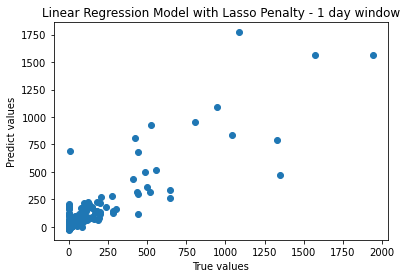

In [185]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Linear Regression Model with Lasso Penalty - 1 day window')
plt.scatter(y_test, y_predict_lr1)
plt.savefig('./lr_1.png')

In [194]:
print(best_estm_lr1.coef_)

[-1.91210137e-01 -3.62247813e-03  2.07179496e-01 -2.56855836e-03
  9.92615729e-02  8.29307965e-02  8.68618839e-02  2.90475465e-01
  2.85805523e-01  1.85323165e-02 -2.78947210e-02  3.20432916e-02
 -4.22802586e-01  4.16173880e-01  3.60344994e-01  1.07694485e-02
  1.51061453e-01 -1.08775425e-01 -3.00442851e-01  3.57740461e-01
  2.48374741e-02 -5.95079722e-01 -2.54575277e+01  0.00000000e+00
  4.64591184e-02 -1.94550313e-01  6.04724444e-03  5.62185754e-05
 -1.98471172e-01]


In [195]:
print(X.columns)

Index(['% people older than 60', 'Population density', 'Daily increase_1d',
       'Daily increase_2d', 'Daily increase_3d', 'Daily increase_4d',
       'Daily increase_5d', 'Daily increase_6d', 'Daily increase_7d',
       'Daily increase_8d', 'Daily increase_9d', 'Daily increase_10d',
       'Social distancing index_1d', 'Social distancing index_2d',
       'Social distancing index_3d', 'Social distancing index_4d',
       'Social distancing index_5d', 'Social distancing index_6d',
       'Social distancing index_7d', 'Social distancing index_8d',
       'Social distancing index_9d', 'Social distancing index_10d',
       'New case/100 people_1d', 'COVID death rate_1d',
       'nearby_avg_dailyinc_1d', 'nearby_avg_socialidx_1d',
       'NUM_LICENSED_BEDS', 'NUM_STAFFED_BEDS', 'AVG_VENTILATOR_USAGE'],
      dtype='object')


In [228]:
from scipy import stats

def generate_OLS(model, X_test, y_predict, y_test):
    X_test = X_test.to_numpy()
        
    params = np.append(model.intercept_,model.coef_)
    newX = pd.DataFrame({"Constant":np.ones(len(X_test))}).join(pd.DataFrame(X_test)).astype(float)

    MSE = (sum((y_predict)**2))/(len(newX) - len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    print(len(newX[0]))
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["p values"] = [params,sd_b,ts_b,p_values]
    print(myDF3)

In [229]:
generate_OLS(best_estm_lr1, X_test, y_predict_lr1, y_test)

454
    Coefficients  Standard Errors  t values  p values
0        16.7580           66.411     0.252       NaN
1        -0.1912            1.589    -0.120       NaN
2        -0.0036            0.021    -0.170       NaN
3         0.2072            0.116     1.789       NaN
4        -0.0026            0.143    -0.018       NaN
5         0.0993            0.125     0.793       NaN
6         0.0829            0.187     0.444       NaN
7         0.0869            0.132     0.659       NaN
8         0.2905            0.129     2.247       NaN
9         0.2858            0.131     2.186       NaN
10        0.0185            0.198     0.094       NaN
11       -0.0279            0.182    -0.154       NaN
12        0.0320            0.155     0.207       NaN
13       -0.4228            2.122    -0.199       NaN
14        0.4162            1.715     0.243       NaN
15        0.3603            1.709     0.211       NaN
16        0.0108            1.242     0.009       NaN
17        0.1511        

In [289]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(best_estm_lr1)
selector.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4425572.353374412, tolerance: 6696.4053300121495
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.3))

In [290]:
selector.estimator_.coef_

array([-1.08850128e-01, -3.85769754e-02,  5.69328334e-01,  2.69265587e-01,
       -3.78946202e-01, -3.23766811e-01,  4.39442908e-02,  3.55872106e-01,
        3.52107373e-02,  7.27229868e-02, -6.80408865e-02,  1.94329769e-01,
       -1.80583811e-01,  1.00237792e-01,  1.46862316e-01, -8.78575658e-01,
       -1.45270452e-01,  1.35853202e-01, -7.07964482e-02, -4.17847322e-02,
       -3.41056051e-01, -3.44061513e-02,  0.00000000e+00,  3.41404814e+01,
        1.11955354e-01,  7.91253571e-01,  7.22871695e-02,  1.45108574e-02,
       -2.05889240e+00])

In [291]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True])

## Fit non-linear model with nested cross validation

In [230]:
parameter = {'max_depth': [20, 30, 40]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, parameter, scoring = 'neg_mean_squared_error')
cv_rf = cross_validate(clf_rf, X_train, y_train, cv = 5, return_estimator = True)

In [231]:
print('CV test score: ', cv_rf['test_score'])
print('mean CV test score', np.mean(cv_rf['test_score']))
index = np.argmax(cv_rf['test_score'])
best_estm_rf1 = cv_rf['estimator'][index].best_estimator_
best_estm_rf1

CV test score:  [-17901.31692948  -8180.25625385  -3923.31522883  -8908.44541394
  -8153.82321243]
mean CV test score -9413.431407703163


RandomForestRegressor(max_depth=30)

In [232]:
r2_rf1 = best_estm_rf1.score(X_test, y_test)
y_predict_rf1 = best_estm_rf1.predict(X_test)
mse_rf1 = mean_squared_error(y_test, y_predict_rf1)
print('R sqaure: ', r2_rf1)
print('rooted MSE: ', np.sqrt(mse_rf1))

R sqaure:  0.8064876447969154
rooted MSE:  84.33583721470895


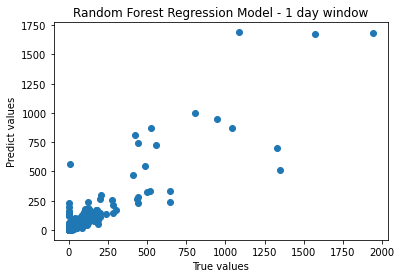

In [233]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Random Forest Regression Model - 1 day window')
plt.scatter(y_test, y_predict_rf1)
plt.savefig('./rf_1.png')

## Benchmark model check

### Benchmark 1: naive average daily increase model

In [234]:
X_test

,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,Daily increase_7d,Daily increase_8d,...,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,AVG_VENTILATOR_USAGE
559,18,2125,364,0,236,417,150,126,129,115,...,75,63,48,0.0198,0.69,28.000000,76.000000,24334.0,23065.0,523.0
689,15,136,0,4,4,3,3,2,9,0,...,45,74,60,0.0097,1.49,1.666667,43.333333,242.0,242.0,12.0
1604,16,106,176,170,207,0,110,280,0,149,...,23,27,31,0.0849,1.56,321.000000,27.000000,4410.0,4650.0,107.0
335,15,108,1,1,2,0,1,0,0,0,...,32,14,15,0.0015,0.31,4.000000,56.000000,1560.0,1497.0,33.0
721,15,136,17,8,4,6,16,0,11,0,...,23,28,29,0.0352,1.76,5.000000,20.000000,242.0,242.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,26,21,0,0,0,0,0,0,0,0,...,12,16,16,0,0.06,0.000000,15.333333,92.0,65.0,4.0
1770,27,47,0,0,0,0,1,0,0,1,...,39,39,64,0,1.5,0.000000,24.000000,590.0,576.0,35.0
956,18,115,28,12,19,65,27,19,35,15,...,29,29,31,0.0451,1.56,8.000000,27.000000,747.0,709.0,14.0
690,15,136,2,0,4,4,3,3,2,9,...,44,45,74,0.0073,1.5,2.000000,40.333333,242.0,242.0,12.0


R square:  0.7944995260999242
rooted MSE:  86.90889439585648


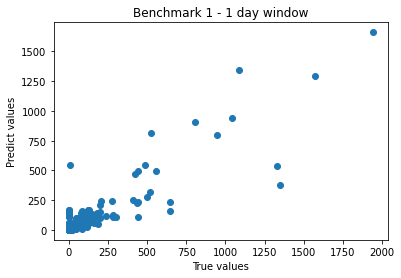

In [236]:
X_test_daily = X_test.iloc[:, 2:12]
#X_test_diff = X_test_daily.diff(axis = 1).abs()
y_predict_b11 = np.mean(X_test_daily, axis = 1)
r2_b11 = r2_score(y_test, y_predict_b11)
mse_b11 = mean_squared_error(y_test, y_predict_b11)
print('R square: ', r2_b11)
print('rooted MSE: ', np.sqrt(mse_b11))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 1 - 1 day window')
plt.scatter(y_test, y_predict_b11)
plt.savefig('./b1_1.png')


### Benchmark 2: naive time series model

CV test score:  [0.82284677 0.82733092 0.84533911 0.81872891 0.81627911]
mean CV test score 0.8261049648842814
R sqaure:  0.7784438581271512
rooted MSE:  90.24012914538204


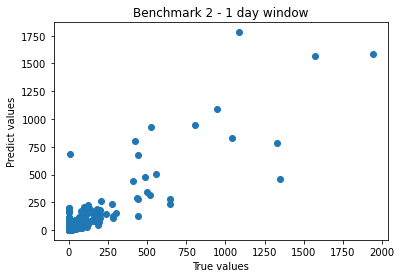

In [237]:
X_train_b2 = X_train.iloc[:, 2:12]
X_test_b2 = X_test.iloc[:, 2:12]

lr_b21 = LinearRegression()
cv_b21 = cross_validate(lr_b21, X_train_b2, y_train, cv = 5, return_estimator = True)
print('CV test score: ', cv_b21['test_score'])
print('mean CV test score', np.mean(cv_b21['test_score']))

index = np.argmax(cv_b21['test_score'])
best_estm_b21 = cv_b21['estimator'][index]
r2_b21= best_estm_b21.score(X_test_b2, y_test)
y_predict_b21 = best_estm_b21.predict(X_test_b2)
mse_b21 = mean_squared_error(y_test, y_predict_b21)
print('R sqaure: ', r2_b21)
print('rooted MSE: ', np.sqrt(mse_b21))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 2 - 1 day window')
plt.scatter(y_test, y_predict_b21)
plt.savefig('./b2_1.png')


In [239]:
print(best_estm_b21.coef_)

[ 0.21471878 -0.00092815  0.10098745  0.08964188  0.0899206   0.295962
  0.29223653  0.0227331  -0.02781428  0.03187199]


# Test models on 10 days period, 30 days period and 60 days period

# 10 days period

In [240]:
df_10d = get_after(df_basic.copy(), 'Daily increase', 'Daily increase_10d_after', 9)
df_10d = df_10d.drop(columns = ['Daily increase'])
df_10d.dropna(inplace = True)
df_10d.head()

,COUNTY_AND_DATE,COUNTY,DATE,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,...,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,AVG_VENTILATOR_USAGE,Daily increase_10d_after
0,"Glenn,California,03/11/2020","Glenn,California",03/11/2020,22,21,0,0,0,0,0,...,19,33,0,0.04,0.0,15.0,47.0,15.0,1.0,0
1,"Glenn,California,03/12/2020","Glenn,California",03/12/2020,22,21,0,0,0,0,0,...,15,19,0,0.06,0.0,15.5,47.0,15.0,1.0,0
2,"Glenn,California,03/13/2020","Glenn,California",03/13/2020,22,21,0,0,0,0,0,...,16,15,0,0.07,0.0,22.0,47.0,15.0,1.0,0
3,"Glenn,California,03/14/2020","Glenn,California",03/14/2020,22,21,0,0,0,0,0,...,18,16,0,0.06,0.0,14.0,47.0,15.0,1.0,0
4,"Glenn,California,03/15/2020","Glenn,California",03/15/2020,22,21,0,0,0,0,0,...,17,18,0,0.07,0.0,34.0,47.0,15.0,1.0,0


In [241]:
df_10d.shape

(2079, 33)

In [242]:
X = df_10d.iloc[:, 3:-1]
y = df_10d.iloc[:, -1]

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Fit linear model with lasso penalty and nested cross validation

In [244]:
parameter = {'alpha': [0.1, 0.2, 0.3]}
lr_lasso = linear_model.Lasso()
#clf_lr = GridSearchCV(lr_lasso, parameter, scoring = ('r2', 'neg_root_mean_squared_error'))
clf_lr = GridSearchCV(lr_lasso, parameter, scoring = 'neg_mean_squared_error')
cv_lr = cross_validate(clf_lr, X_train, y_train, cv = 5, return_estimator = True)

# cv_lr_score = cross_val_score(clf_lr, X_train, y_train)
# cv_lr_score

#clf_lr.fit(X_train, y_train)

#cv_lr['test_score']
#cv_result = cross_validate(reg, X_train, y_train, cv = 5, return_estimator = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4298431.380845516, tolerance: 5555.029169548875
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4327311.411098555, tolerance: 4851.345678101503
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3002501.515417376, tolerance: 4431.118428571429
  model = cd_fast.enet_coordinate_descent(
/Lib

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3883597.381117939, tolerance: 5937.212822180456
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4928765.7415095875, tolerance: 6577.579692387221
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5688265.75056866, tolerance: 7392.245568045111
  model = cd_fast.enet_coordinate_descent(
/Lib

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4944607.778152348, tolerance: 6545.666170328638
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3712035.9984150054, tolerance: 5134.489683834587
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4285803.590564945, tolerance: 5419.442182159623
  model = cd_fast.enet_coordinate_descent(
/Li

In [245]:
print('CV test score: ', cv_lr['test_score'])
print('mean CV test score', np.mean(cv_lr['test_score']))
index = np.argmax(cv_lr['test_score'])
best_estm_lr10 = cv_lr['estimator'][index].best_estimator_
best_estm_lr10

CV test score:  [-16556.835204    -7493.54591214 -13939.91197248 -12638.18788443
  -6699.9176662 ]
mean CV test score -11465.679727850391


Lasso(alpha=0.3)

In [246]:
r2_lr10 = best_estm_lr10.score(X_test, y_test)
y_predict_lr10 = best_estm_lr10.predict(X_test)
mse_lr10 = mean_squared_error(y_test, y_predict_lr10)
print('R sqaure: ', r2_lr10)
print('rooted MSE: ', np.sqrt(mse_lr10))

R sqaure:  0.8232374572851686
rooted MSE:  110.50858751895353


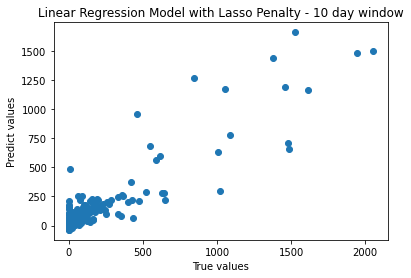

In [247]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Linear Regression Model with Lasso Penalty - 10 day window')
plt.scatter(y_test, y_predict_lr10)
plt.savefig('./lr_10.png')

In [263]:
print(best_estm_lr10.coef_)
print(X_test.columns.values)

[-0.32758754 -0.01014459  0.17045445  0.06729857 -0.00952446  0.08362631
  0.25266328  0.13633702  0.1832964   0.07593366  0.05130611 -0.06423345
 -0.26631251  0.698017    0.66774474 -0.32056948 -0.61656436 -0.33004486
  0.4707049   0.72505497 -0.55577862 -0.7899726   0.          1.48340989
  0.07601831 -0.45627352  0.02545806 -0.00718518 -0.36512604]
['% people older than 60' 'Population density' 'Daily increase_1d'
 'Daily increase_2d' 'Daily increase_3d' 'Daily increase_4d'
 'Daily increase_5d' 'Daily increase_6d' 'Daily increase_7d'
 'Daily increase_8d' 'Daily increase_9d' 'Daily increase_10d'
 'Social distancing index_1d' 'Social distancing index_2d'
 'Social distancing index_3d' 'Social distancing index_4d'
 'Social distancing index_5d' 'Social distancing index_6d'
 'Social distancing index_7d' 'Social distancing index_8d'
 'Social distancing index_9d' 'Social distancing index_10d'
 'New case/100 people_1d' 'COVID death rate_1d' 'nearby_avg_dailyinc_1d'
 'nearby_avg_socialidx_1d'

In [292]:
selector = SelectFromModel(best_estm_lr10)
selector.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4425572.353374412, tolerance: 6696.4053300121495
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.3))

In [293]:
selector.estimator_.coef_

array([-1.08850128e-01, -3.85769754e-02,  5.69328334e-01,  2.69265587e-01,
       -3.78946202e-01, -3.23766811e-01,  4.39442908e-02,  3.55872106e-01,
        3.52107373e-02,  7.27229868e-02, -6.80408865e-02,  1.94329769e-01,
       -1.80583811e-01,  1.00237792e-01,  1.46862316e-01, -8.78575658e-01,
       -1.45270452e-01,  1.35853202e-01, -7.07964482e-02, -4.17847322e-02,
       -3.41056051e-01, -3.44061513e-02,  0.00000000e+00,  3.41404814e+01,
        1.11955354e-01,  7.91253571e-01,  7.22871695e-02,  1.45108574e-02,
       -2.05889240e+00])

In [294]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True])

## Fit non-linear model with nested cross validation

In [249]:
parameter = {'max_depth': [20, 30, 40]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, parameter, scoring = 'neg_mean_squared_error')
cv_rf = cross_validate(clf_rf, X_train, y_train, cv = 5, return_estimator = True)

In [250]:
print('CV test score: ', cv_rf['test_score'])
print('mean CV test score', np.mean(cv_rf['test_score']))
index = np.argmax(cv_rf['test_score'])
best_estm_rf10 = cv_rf['estimator'][index].best_estimator_
best_estm_rf10

CV test score:  [-12816.19788228  -5594.47716964 -12428.65848318 -11762.02232623
  -5382.27761627]
mean CV test score -9596.726695518719


RandomForestRegressor(max_depth=40)

In [251]:
r2_rf10 = best_estm_rf10.score(X_test, y_test)
y_predict_rf10 = best_estm_rf10.predict(X_test)
mse_rf10 = mean_squared_error(y_test, y_predict_rf10)
print('R sqaure: ', r2_rf10)
print('rooted MSE: ', np.sqrt(mse_rf10))

R sqaure:  0.8268852056919579
rooted MSE:  109.3623918018667


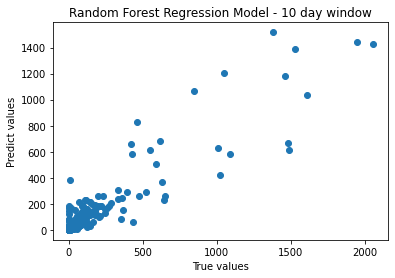

In [252]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Random Forest Regression Model - 10 day window')
plt.scatter(y_test, y_predict_rf10)
plt.savefig('./rf_10.png')

## Benchmark model check

### Benchmark 1: naive average daily increase model

R square:  0.7308458203708456
rooted MSE:  136.3645463278205


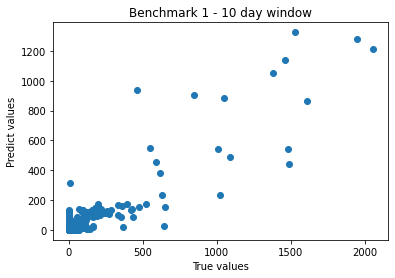

In [253]:
X_test_daily = X_test.iloc[:, 2:12]
y_predict_b110 = np.mean(X_test_daily, axis = 1)
r2_b110 = r2_score(y_test, y_predict_b110)
mse_b110 = mean_squared_error(y_test, y_predict_b110)
print('R square: ', r2_b110)
print('rooted MSE: ', np.sqrt(mse_b110))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 1 - 10 day window')
plt.scatter(y_test, y_predict_b110)
plt.savefig('./b1_10.png')


### Benchmark 2: naive time series model

CV test score:  [0.81408856 0.78692023 0.73164378 0.78883829 0.72561197]
mean CV test score 0.7694205683518712
R sqaure:  0.7930454459454269
rooted MSE:  119.57445265850691


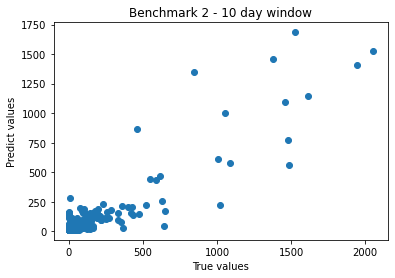

In [254]:
X_train_b2 = X_train.iloc[:, 2:12]
X_test_b2 = X_test.iloc[:, 2:12]

lr_b210 = LinearRegression()
cv_b210 = cross_validate(lr_b210, X_train_b2, y_train, cv = 5, return_estimator = True)
print('CV test score: ', cv_b210['test_score'])
print('mean CV test score', np.mean(cv_b210['test_score']))

index = np.argmax(cv_b210['test_score'])
best_estm_b210 = cv_b210['estimator'][index]
r2_b210= best_estm_b210.score(X_test_b2, y_test)
y_predict_b210 = best_estm_b210.predict(X_test_b2)
mse_b210 = mean_squared_error(y_test, y_predict_b210)
print('R sqaure: ', r2_b210)
print('rooted MSE: ', np.sqrt(mse_b210))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 2 - 10 day window')
plt.scatter(y_test, y_predict_b210)
plt.savefig('./b2_10.png')


## 30 days period

In [255]:
df_30d = get_after(df_basic.copy(), 'Daily increase', 'Daily increase_30d_after', 29)
df_30d = df_30d.drop(columns = ['Daily increase'])
df_30d.dropna(inplace = True)
df_30d.head()

,COUNTY_AND_DATE,COUNTY,DATE,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,...,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,AVG_VENTILATOR_USAGE,Daily increase_30d_after
0,"Glenn,California,03/11/2020","Glenn,California",03/11/2020,22,21,0,0,0,0,0,...,19,33,0,0.04,0.0,15.0,47.0,15.0,1.0,0
1,"Glenn,California,03/12/2020","Glenn,California",03/12/2020,22,21,0,0,0,0,0,...,15,19,0,0.06,0.0,15.5,47.0,15.0,1.0,1
2,"Glenn,California,03/13/2020","Glenn,California",03/13/2020,22,21,0,0,0,0,0,...,16,15,0,0.07,0.0,22.0,47.0,15.0,1.0,0
3,"Glenn,California,03/14/2020","Glenn,California",03/14/2020,22,21,0,0,0,0,0,...,18,16,0,0.06,0.0,14.0,47.0,15.0,1.0,0
4,"Glenn,California,03/15/2020","Glenn,California",03/15/2020,22,21,0,0,0,0,0,...,17,18,0,0.07,0.0,34.0,47.0,15.0,1.0,0


In [256]:
df_30d.shape

(1659, 33)

In [257]:
X = df_30d.iloc[:, 3:-1]
y = df_30d.iloc[:, -1]

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fit linear model with lasso penalty and nested cross validation

In [259]:
parameter = {'alpha': [0.1, 0.2, 0.3]}
lr_lasso = linear_model.Lasso()
clf_lr = GridSearchCV(lr_lasso, parameter, scoring = 'neg_mean_squared_error')
cv_lr = cross_validate(clf_lr, X_train, y_train, cv = 5, return_estimator = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2737464.0673685796, tolerance: 4297.127340448116
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3499410.035458721, tolerance: 4674.4250553592465
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3061854.459360711, tolerance: 4223.078057479387
  model = cd_fast.enet_coordinate_descent(
/L

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5736598.434001102, tolerance: 7591.698308199814
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4244967.559667838, tolerance: 5772.397689988222
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3989039.7756410656, tolerance: 5394.256328621911
  model = cd_fast.enet_coordinate_descent(
/Li

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5951602.942763795, tolerance: 7368.1885586629
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4062573.9659126773, tolerance: 5488.775340164903
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3160373.1057523466, tolerance: 5111.376846878679
  model = cd_fast.enet_coordinate_descent(
/Lib

In [260]:
print('CV test score: ', cv_lr['test_score'])
print('mean CV test score', np.mean(cv_lr['test_score']))
index = np.argmax(cv_lr['test_score'])
best_estm_lr30 = cv_lr['estimator'][index].best_estimator_
best_estm_lr30

CV test score:  [-27225.6715514  -10348.39217699 -10132.15709924  -9927.52823743
 -11382.16884589]
mean CV test score -13803.18358218842


Lasso(alpha=0.1)

In [261]:
r2_lr30 = best_estm_lr30.score(X_test, y_test)
y_predict_lr30 = best_estm_lr30.predict(X_test)
mse_lr30 = mean_squared_error(y_test, y_predict_lr30)
print('R sqaure: ', r2_lr30)
print('rooted MSE: ', np.sqrt(mse_lr30))

R sqaure:  0.8109551675288594
rooted MSE:  120.79255419926197


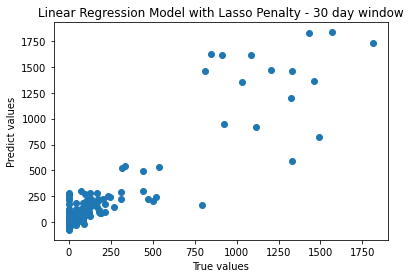

In [262]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Linear Regression Model with Lasso Penalty - 30 day window')
plt.scatter(y_test, y_predict_lr30)
plt.savefig('./lr_30.png')


In [264]:
print(best_estm_lr30.coef_)
print(X_test.columns.values)

[-1.36768662e-01 -2.57848568e-02  3.30986753e-01 -2.29948790e-02
  3.15385896e-03 -4.31607143e-02  1.89255032e-01  1.39625215e-01
  1.68737174e-01  1.24651482e-01  2.11755388e-01  5.37656976e-02
  3.42124642e-01  7.23758354e-01  7.02295556e-01 -1.77601769e-01
 -2.16467474e-01 -1.27600302e+00  4.88105267e-02  4.05756371e-01
 -9.24150857e-01 -9.08957635e-01  1.96664957e+02  1.51113866e+01
  1.63646669e-01 -4.45831409e-01  5.22160351e-02 -7.47266627e-03
 -1.04570897e+00]
['% people older than 60' 'Population density' 'Daily increase_1d'
 'Daily increase_2d' 'Daily increase_3d' 'Daily increase_4d'
 'Daily increase_5d' 'Daily increase_6d' 'Daily increase_7d'
 'Daily increase_8d' 'Daily increase_9d' 'Daily increase_10d'
 'Social distancing index_1d' 'Social distancing index_2d'
 'Social distancing index_3d' 'Social distancing index_4d'
 'Social distancing index_5d' 'Social distancing index_6d'
 'Social distancing index_7d' 'Social distancing index_8d'
 'Social distancing index_9d' 'Social di

In [295]:
selector = SelectFromModel(best_estm_lr30)
selector.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4412778.602023124, tolerance: 6696.4053300121495
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.1))

In [296]:
selector.estimator_.coef_

array([ 8.00626284e-02, -3.73982753e-02,  5.58294677e-01,  2.55377780e-01,
       -3.94602866e-01, -3.21857465e-01,  4.55602737e-02,  3.56897169e-01,
        3.40786110e-02,  7.36653862e-02, -6.56165191e-02,  1.96100920e-01,
       -1.78418135e-01,  1.18748679e-01,  1.85689157e-01, -8.89539111e-01,
       -1.81567233e-01,  9.38247760e-02, -1.08499668e-01, -7.49890378e-02,
       -3.76572260e-01, -1.00896845e-01,  3.70400050e+02,  3.47319179e+01,
        1.04687494e-01,  7.85701423e-01,  7.25840571e-02,  1.42785190e-02,
       -2.05594253e+00])

In [297]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### Fit non-linear model with nested cross validation

In [265]:
parameter = {'max_depth': [20, 30, 40]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, parameter, scoring = 'neg_mean_squared_error')
cv_rf = cross_validate(clf_rf, X_train, y_train, cv = 5, return_estimator = True)

In [266]:
print('CV test score: ', cv_rf['test_score'])
print('mean CV test score', np.mean(cv_rf['test_score']))
index = np.argmax(cv_rf['test_score'])
best_estm_rf30 = cv_rf['estimator'][index].best_estimator_
best_estm_rf30

CV test score:  [-25641.79332657  -9325.03110593  -8264.10401057  -8661.50354453
 -10124.17396264]
mean CV test score -12403.321190046685


RandomForestRegressor(max_depth=40)

In [267]:
r2_rf30 = best_estm_rf30.score(X_test, y_test)
y_predict_rf30 = best_estm_rf30.predict(X_test)
mse_rf30 = mean_squared_error(y_test, y_predict_rf30)
print('R sqaure: ', r2_rf30)
print('rooted MSE: ', np.sqrt(mse_rf30))

R sqaure:  0.841456095369878
rooted MSE:  110.61971477947124


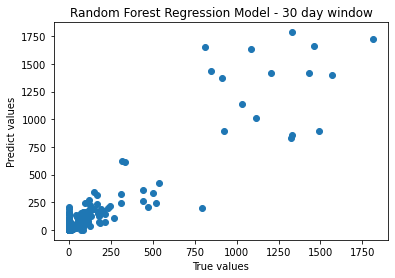

In [268]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Random Forest Regression Model - 30 day window')
plt.scatter(y_test, y_predict_rf30)
plt.savefig('./rf_30.png')


### Benchmark 1: naive average daily increase model

R square:  0.6438021672955013
rooted MSE:  165.8072039615353


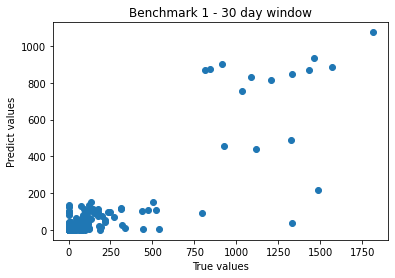

In [269]:
X_test_daily = X_test.iloc[:, 2:12]
y_predict_b130 = np.mean(X_test_daily, axis = 1)
r2_b130 = r2_score(y_test, y_predict_b130)
mse_b130 = mean_squared_error(y_test, y_predict_b130)
print('R square: ', r2_b130)
print('rooted MSE: ', np.sqrt(mse_b130))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 1 - 30 day window')
plt.scatter(y_test, y_predict_b130)
plt.savefig('./b1_30.png')


### Benchmark 2: naive time series model

CV test score:  [0.73986603 0.6879424  0.74666707 0.7658044  0.77672099]
mean CV test score 0.7434001773370701
R sqaure:  0.7382393219301331
rooted MSE:  142.13792232799184


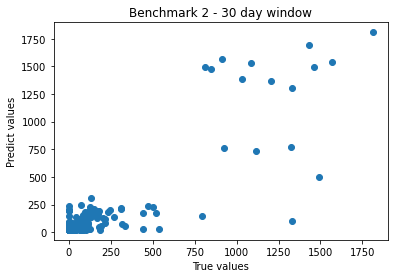

In [270]:
X_train_b2 = X_train.iloc[:, 2:12]
X_test_b2 = X_test.iloc[:, 2:12]

lr_b230 = LinearRegression()
cv_b230 = cross_validate(lr_b230, X_train_b2, y_train, cv = 5, return_estimator = True)
print('CV test score: ', cv_b230['test_score'])
print('mean CV test score', np.mean(cv_b230['test_score']))

index = np.argmax(cv_b230['test_score'])
best_estm_b230 = cv_b230['estimator'][index]
r2_b230= best_estm_b230.score(X_test_b2, y_test)
y_predict_b230 = best_estm_b230.predict(X_test_b2)
mse_b230 = mean_squared_error(y_test, y_predict_b230)
print('R sqaure: ', r2_b230)
print('rooted MSE: ', np.sqrt(mse_b230))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 2 - 30 day window')
plt.scatter(y_test, y_predict_b230)
plt.savefig('./b2_30.png')


## 60 days period

In [271]:
df_60d = get_after(df_basic.copy(), 'Daily increase', 'Daily increase_30d_after', 59)
df_60d = df_60d.drop(columns = ['Daily increase'])
df_60d.dropna(inplace = True)
df_60d.head()

,COUNTY_AND_DATE,COUNTY,DATE,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,...,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,AVG_VENTILATOR_USAGE,Daily increase_30d_after
0,"Glenn,California,03/11/2020","Glenn,California",03/11/2020,22,21,0,0,0,0,0,...,19,33,0,0.04,0.0,15.0,47.0,15.0,1.0,0
1,"Glenn,California,03/12/2020","Glenn,California",03/12/2020,22,21,0,0,0,0,0,...,15,19,0,0.06,0.0,15.5,47.0,15.0,1.0,0
2,"Glenn,California,03/13/2020","Glenn,California",03/13/2020,22,21,0,0,0,0,0,...,16,15,0,0.07,0.0,22.0,47.0,15.0,1.0,0
3,"Glenn,California,03/14/2020","Glenn,California",03/14/2020,22,21,0,0,0,0,0,...,18,16,0,0.06,0.0,14.0,47.0,15.0,1.0,0
4,"Glenn,California,03/15/2020","Glenn,California",03/15/2020,22,21,0,0,0,0,0,...,17,18,0,0.07,0.0,34.0,47.0,15.0,1.0,0


In [272]:
df_60d.shape

(1029, 33)

In [273]:
X = df_60d.iloc[:, 3:-1]
y = df_60d.iloc[:, -1]

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fit linear model with lasso penalty and nested cross validation

In [275]:
parameter = {'alpha': [0.1, 0.2, 0.3]}
lr_lasso = linear_model.Lasso()
clf_lr = GridSearchCV(lr_lasso, parameter, scoring = 'neg_mean_squared_error')
cv_lr = cross_validate(clf_lr, X_train, y_train, cv = 5, return_estimator = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2819258.6834362787, tolerance: 5180.89438631179
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3038691.290240137, tolerance: 4947.372710456271
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2892238.914228068, tolerance: 5066.7378055133095
  model = cd_fast.enet_coordinate_descent(
/Li

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2988360.797079531, tolerance: 5010.90365798479
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2952064.459637951, tolerance: 4525.899532509508
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2645527.3187808194, tolerance: 4480.303207604563
  model = cd_fast.enet_coordinate_descent(
/Lib

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2121834.6257648473, tolerance: 3658.7483578747615
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1941400.7112208533, tolerance: 3293.4740060606064
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2332089.446984062, tolerance: 4275.820110056928
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2526374.2628853773, tolerance: 4012.405946869069
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2233357.889419733, tolerance: 3336.8043498106053
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3419728.743312751, tolerance: 5078.945876176024
  model = cd_fast.enet_coordinate_descent(


In [276]:
print('CV test score: ', cv_lr['test_score'])
print('mean CV test score', np.mean(cv_lr['test_score']))
index = np.argmax(cv_lr['test_score'])
best_estm_lr60 = cv_lr['estimator'][index].best_estimator_
best_estm_lr60

CV test score:  [ -9500.91574193 -12370.75334462 -12478.78089741 -35805.57197712
 -15397.11841126]
mean CV test score -17110.62807447017


Lasso(alpha=0.3)

In [277]:
r2_lr60 = best_estm_lr60.score(X_test, y_test)
y_predict_lr60 = best_estm_lr60.predict(X_test)
mse_lr60 = mean_squared_error(y_test, y_predict_lr60)
print('R sqaure: ', r2_lr60)
print('rooted MSE: ', np.sqrt(mse_lr60))

R sqaure:  0.8282111218165098
rooted MSE:  147.47408878725852


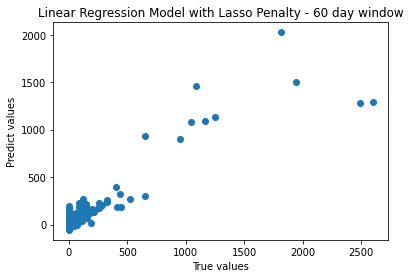

In [278]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Linear Regression Model with Lasso Penalty - 60 day window')
plt.scatter(y_test, y_predict_lr60)
plt.savefig('./lr_60.png')


In [279]:
print(best_estm_lr60.coef_)
print(X_test.columns.values)

[ 9.13730897e-02 -3.55475511e-02  7.05528668e-01  1.90360702e-01
 -4.20316063e-01 -3.54292120e-01  1.07618075e-01  4.39401849e-01
  1.61404827e-01  3.49089552e-02 -2.29649864e-01  1.93567117e-01
 -3.46737485e-01  3.99777306e-01 -1.51876562e-01 -7.24490123e-01
  3.52910221e-02  2.46881019e-01 -3.00972796e-01  6.21959124e-02
 -7.08881244e-01  2.57399950e-01  0.00000000e+00  2.72545054e+01
  6.71943298e-02  1.13458674e+00  6.15396012e-02  2.58743023e-02
 -2.11002499e+00]
['% people older than 60' 'Population density' 'Daily increase_1d'
 'Daily increase_2d' 'Daily increase_3d' 'Daily increase_4d'
 'Daily increase_5d' 'Daily increase_6d' 'Daily increase_7d'
 'Daily increase_8d' 'Daily increase_9d' 'Daily increase_10d'
 'Social distancing index_1d' 'Social distancing index_2d'
 'Social distancing index_3d' 'Social distancing index_4d'
 'Social distancing index_5d' 'Social distancing index_6d'
 'Social distancing index_7d' 'Social distancing index_8d'
 'Social distancing index_9d' 'Social di

In [298]:
selector = SelectFromModel(best_estm_lr60)
selector.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4425572.353374412, tolerance: 6696.4053300121495
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.3))

In [299]:
selector.estimator_.coef_

array([-1.08850128e-01, -3.85769754e-02,  5.69328334e-01,  2.69265587e-01,
       -3.78946202e-01, -3.23766811e-01,  4.39442908e-02,  3.55872106e-01,
        3.52107373e-02,  7.27229868e-02, -6.80408865e-02,  1.94329769e-01,
       -1.80583811e-01,  1.00237792e-01,  1.46862316e-01, -8.78575658e-01,
       -1.45270452e-01,  1.35853202e-01, -7.07964482e-02, -4.17847322e-02,
       -3.41056051e-01, -3.44061513e-02,  0.00000000e+00,  3.41404814e+01,
        1.11955354e-01,  7.91253571e-01,  7.22871695e-02,  1.45108574e-02,
       -2.05889240e+00])

In [300]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True])

### Fit non-linear model with nested cross validation

In [280]:
parameter = {'max_depth': [20, 30, 40]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, parameter, scoring = 'neg_mean_squared_error')
cv_rf = cross_validate(clf_rf, X_train, y_train, cv = 5, return_estimator = True)

In [281]:
print('CV test score: ', cv_rf['test_score'])
print('mean CV test score', np.mean(cv_rf['test_score']))
index = np.argmax(cv_rf['test_score'])
best_estm_rf60 = cv_rf['estimator'][index].best_estimator_
best_estm_rf60

CV test score:  [ -8419.38264817  -9837.92301333 -10275.66868545 -16371.72930976
 -11301.98645864]
mean CV test score -11241.338023070337


RandomForestRegressor(max_depth=20)

In [282]:
r2_rf60 = best_estm_rf60.score(X_test, y_test)
y_predict_rf60 = best_estm_rf60.predict(X_test)
mse_rf60 = mean_squared_error(y_test, y_predict_rf60)
print('R sqaure: ', r2_rf60)
print('rooted MSE: ', np.sqrt(mse_rf60))

R sqaure:  0.8262112851535784
rooted MSE:  148.329996141697


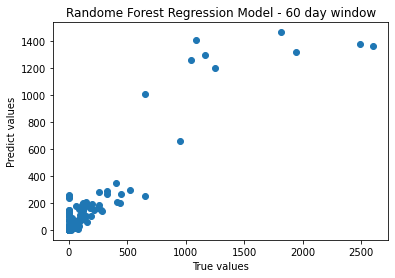

In [283]:
fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Randome Forest Regression Model - 60 day window')
plt.scatter(y_test, y_predict_rf60)
plt.savefig('./rf_60.png')


### Benchmark 1: naive average daily increase model

In [284]:
max(y_test)

2603

R square:  0.4947510986665232
rooted MSE:  252.91284590024134


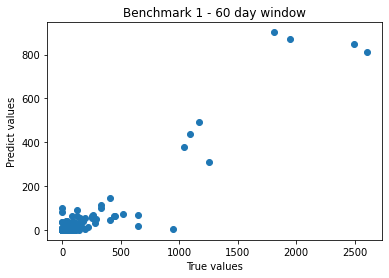

In [285]:
X_test_daily = X_test.iloc[:, 2:12]
y_predict_b160 = np.mean(X_test_daily, axis = 1)
r2_b160 = r2_score(y_test, y_predict_b160)
mse_b160 = mean_squared_error(y_test, y_predict_b160)
print('R square: ', r2_b160)
print('rooted MSE: ', np.sqrt(mse_b160))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 1 - 60 day window')
plt.scatter(y_test, y_predict_b160)
plt.savefig('./b1_60.png')


### Benchmark 2: naive time series model

CV test score:  [0.36661912 0.64027264 0.43136173 0.3090993  0.49994742]
mean CV test score 0.4494600410323499
R sqaure:  0.7970578041206552
rooted MSE:  160.28924276121563


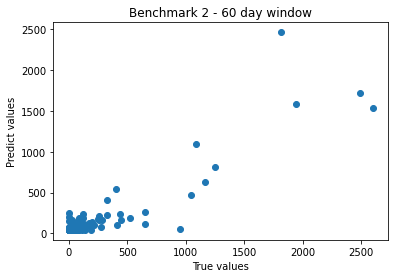

In [286]:
X_train_b2 = X_train.iloc[:, 2:12]
X_test_b2 = X_test.iloc[:, 2:12]

lr_b260 = LinearRegression()
cv_b260 = cross_validate(lr_b260, X_train_b2, y_train, cv = 5, return_estimator = True)
print('CV test score: ', cv_b260['test_score'])
print('mean CV test score', np.mean(cv_b260['test_score']))

index = np.argmax(cv_b260['test_score'])
best_estm_b260 = cv_b260['estimator'][index]
r2_b260= best_estm_b260.score(X_test_b2, y_test)
y_predict_b260 = best_estm_b260.predict(X_test_b2)
mse_b260 = mean_squared_error(y_test, y_predict_b260)
print('R sqaure: ', r2_b260)
print('rooted MSE: ', np.sqrt(mse_b260))

fig = plt.figure()
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.title('Benchmark 2 - 60 day window')
plt.scatter(y_test, y_predict_b260)
plt.savefig('./b2_60.png')


# Save models

In [2]:
import joblib

In [387]:
joblib.dump(best_estm_lr1, './model/lr_1.sav')
joblib.dump(best_estm_lr10, './model/lr_10.sav')
joblib.dump(best_estm_lr30, './model/lr_30.sav')
joblib.dump(best_estm_lr60, './model/lr_60.sav')

['./model/lr_60.sav']

In [388]:
joblib.dump(best_estm_rf1, './model/rf_1.sav')
joblib.dump(best_estm_rf10, './model/rf_10.sav')
joblib.dump(best_estm_rf30, './model/rf_30.sav')
joblib.dump(best_estm_rf60, './model/rf_60.sav')

['./model/rf_60.sav']

In [3]:
# How to load model
loaded_model = joblib.load('./model/rf_1.sav')

# Temporal analysis

# Geographic analysis

In [43]:
# Reload dataset
df_basic = pd.read_csv('./data/basic_data.csv', index_col = 0)
df_basic.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,AVG_VENTILATOR_USAGE
0,"Autauga,Alabama,03/11/2020","Autauga,Alabama",03/11/2020,0,19,91,0,0,0,0,...,10,11,35,0.0,0.0,0.0,13.8,85.0,55.0,2.0
1,"Autauga,Alabama,03/12/2020","Autauga,Alabama",03/12/2020,0,19,91,0,0,0,0,...,19,10,11,0.0,0.0,0.0,11.8,85.0,55.0,2.0
2,"Autauga,Alabama,03/13/2020","Autauga,Alabama",03/13/2020,0,19,91,0,0,0,0,...,12,19,10,0.0,0.0,0.0,9.2,85.0,55.0,2.0
3,"Autauga,Alabama,03/14/2020","Autauga,Alabama",03/14/2020,0,19,91,0,0,0,0,...,9,12,19,0.0,0.0,0.2,10.6,85.0,55.0,2.0
4,"Autauga,Alabama,03/15/2020","Autauga,Alabama",03/15/2020,0,19,91,0,0,0,0,...,21,9,12,0.0,0.0,0.4,26.6,85.0,55.0,2.0


In [5]:
# df_10d = get_after(df_basic.copy(), 'Daily increase', 'Daily increase_10d_after', 9)
# df_10d = df_10d.drop(columns = ['Daily increase'])
# df_10d.dropna(inplace = True)
# df_10d.head()

In [6]:
df_fips = pd.read_csv('/Users/junyiguo/Documents/summer_project/social_mobility_data/fips-counties.csv', 
                      usecols = ['fips', 'county_name', 'state_name'])
df_fips.head()

,fips,county_name,state_name
0,1001,Autauga County,Alabama
1,1003,Baldwin County,Alabama
2,1005,Barbour County,Alabama
3,1007,Bibb County,Alabama
4,1009,Blount County,Alabama


In [7]:
df_fips['fips'] = df_fips['fips'].apply(lambda x: '{:05}'.format(x))
df_fips['county_name'] = df_fips['county_name'].apply(lambda x: x.replace(str(' County'), ''))
df_fips['COUNTY'] = df_fips['county_name'] + str(',') + df_fips['state_name']
df_fips.head()

,fips,county_name,state_name,COUNTY
0,01001,Autauga,Alabama,"Autauga,Alabama"
1,01003,Baldwin,Alabama,"Baldwin,Alabama"
2,01005,Barbour,Alabama,"Barbour,Alabama"
3,01007,Bibb,Alabama,"Bibb,Alabama"
4,01009,Blount,Alabama,"Blount,Alabama"


In [8]:
df_fips.drop(columns = ['county_name', 'state_name'], inplace = True)
df_fips.head()

,fips,COUNTY
0,01001,"Autauga,Alabama"
1,01003,"Baldwin,Alabama"
2,01005,"Barbour,Alabama"
3,01007,"Bibb,Alabama"
4,01009,"Blount,Alabama"


In [9]:
# Check duplicate rows
seen = {}
dupes = []

for x in df_fips['fips']:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
dupes

['11001']

In [10]:
idx = df_fips[df_fips['fips'] == '11001'].index.values[0]
df_fips = df_fips.drop(index = idx)
df_fips.shape

(3145, 2)

In [11]:
df_basic.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx_1d,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,AVG_VENTILATOR_USAGE
0,"Autauga,Alabama,03/11/2020","Autauga,Alabama",03/11/2020,0,19,91,0,0,0,0,...,10,11,35,0.0,0.0,0.0,13.8,85.0,55.0,2.0
1,"Autauga,Alabama,03/12/2020","Autauga,Alabama",03/12/2020,0,19,91,0,0,0,0,...,19,10,11,0.0,0.0,0.0,11.8,85.0,55.0,2.0
2,"Autauga,Alabama,03/13/2020","Autauga,Alabama",03/13/2020,0,19,91,0,0,0,0,...,12,19,10,0.0,0.0,0.0,9.2,85.0,55.0,2.0
3,"Autauga,Alabama,03/14/2020","Autauga,Alabama",03/14/2020,0,19,91,0,0,0,0,...,9,12,19,0.0,0.0,0.2,10.6,85.0,55.0,2.0
4,"Autauga,Alabama,03/15/2020","Autauga,Alabama",03/15/2020,0,19,91,0,0,0,0,...,21,9,12,0.0,0.0,0.4,26.6,85.0,55.0,2.0


In [15]:
X = df_basic.iloc[:, 4:]
y = df_basic.iloc[:, 3]

In [16]:
y_predict = loaded_model.predict(X)

In [19]:
df_predict = pd.DataFrame({'COUNTY': df_basic['COUNTY'], 'y': y, 'y_predict': y_predict})
df_predict.shape

(252072, 3)

In [20]:
df_geo = pd.merge(df_fips, df_predict, how = 'right', on = 'COUNTY')
df_geo.dropna(inplace = True)
df_geo.shape

(252072, 4)

In [21]:
df_geo.head()

,fips,COUNTY,y,y_predict
0,01001,"Autauga,Alabama",0,0.012850
1,01001,"Autauga,Alabama",0,0.014996
2,01001,"Autauga,Alabama",0,0.012410
3,01001,"Autauga,Alabama",0,0.064733
4,01001,"Autauga,Alabama",0,0.056964


In [24]:
geo_group = df_geo.groupby(by = 'fips')
fips_key = list(geo_group.groups.keys())
mse_list = []
#df_geo_group.get_group('Autauga,Alabama')
for key in fips_key:
    df = geo_group.get_group(key)
    mse = mean_squared_error(df['y'], df['y_predict'])
    mse_list.append(np.sqrt(mse))
print(len(fips_key), len(mse_list))

2334 2334


In [4]:
#import plotly.figure_factory as ff
#from plotly.tools import FigureFactory as ff
from plotly.figure_factory import create_choropleth

In [5]:
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(0, 1000, len(colorscale) - 1))

fig = create_choropleth(
    fips = fips_key, values = mse_list,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='COVID19 Positive Test Prediction',
    legend_title='Rooted Mean Squared Error'
)

fig.layout.template = None
fig.show()

NameError: name 'fips_key' is not defined

# Plot daily increase

In [27]:
!conda install geopandas

zsh:1: command not found: conda


In [30]:
! pip3 install shapely==1.6.3

  Using cached Shapely-1.6.3.tar.gz (223 kB)
    ERROR: Command errored out with exit status 1:
     command: /Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/rp/zw4ql_7d1070bpxp9yqhq1cw0000gn/T/pip-install-velo2jzj/shapely/setup.py'"'"'; __file__='"'"'/private/var/folders/rp/zw4ql_7d1070bpxp9yqhq1cw0000gn/T/pip-install-velo2jzj/shapely/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/rp/zw4ql_7d1070bpxp9yqhq1cw0000gn/T/pip-pip-egg-info-j56mbfol
         cwd: /private/var/folders/rp/zw4ql_7d1070bpxp9yqhq1cw0000gn/T/pip-install-velo2jzj/shapely/
    Complete output (11 lines):
    Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`
    Failed `CDLL(/opt/local/lib/libgeos_c.dylib)`
    Traceback (most recent call l

In [ ]:
! y

In [412]:
!pip install plotly-geo

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
min(mse_list)

In [ ]:
max(mse_list)

In [ ]:
mse_list

### Subset the data from California and Massachusetts to test the model

In [294]:
df_MACA = df_mobility_COVID19_new[df_mobility_COVID19_new['COUNTY'].str.contains('Massachusetts|California')]
df_MACA.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density
18526,"Alameda,California,03/01/2020","Alameda,California",03/01/2020,0,37,0.0000,0.00,19,2002
18527,"Alameda,California,03/02/2020","Alameda,California",03/02/2020,0,17,0.0000,0.00,19,2002
18528,"Alameda,California,03/03/2020","Alameda,California",03/03/2020,1,16,0.0002,0.00,19,2002
18529,"Alameda,California,03/04/2020","Alameda,California",03/04/2020,0,14,0.0002,0.03,19,2002
18530,"Alameda,California,03/05/2020","Alameda,California",03/05/2020,0,15,0.0002,0.03,19,2002


In [295]:
df_sub = df_MACA.iloc[:20]
df_sub

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density
18526,"Alameda,California,03/01/2020","Alameda,California",03/01/2020,0,37,0.0000,0.00,19,2002
18527,"Alameda,California,03/02/2020","Alameda,California",03/02/2020,0,17,0.0000,0.00,19,2002
18528,"Alameda,California,03/03/2020","Alameda,California",03/03/2020,1,16,0.0002,0.00,19,2002
18529,"Alameda,California,03/04/2020","Alameda,California",03/04/2020,0,14,0.0002,0.03,19,2002
18530,"Alameda,California,03/05/2020","Alameda,California",03/05/2020,0,15,0.0002,0.03,19,2002
18531,"Alameda,California,03/06/2020","Alameda,California",03/06/2020,0,14,0.0000,0.03,19,2002
18532,"Alameda,California,03/07/2020","Alameda,California",03/07/2020,1,32,0.0002,0.03,19,2002
18533,"Alameda,California,03/08/2020","Alameda,California",03/08/2020,0,41,0.0002,0.03,19,2002
18534,"Alameda,California,03/09/2020","Alameda,California",03/09/2020,0,21,0.0002,0.02,19,2002
18535,"Alameda,California,03/10/2020","Alameda,California",03/10/2020,1,19,0.0002,0.04,19,2002


In [298]:
period_date = 10
for period in range(1, period_date + 1):
    new_col_name = 'Daily increase_' + str(period) + 'd'
    df_MACA = get_previous(df_MACA.copy(), 'Daily increase', new_col_name, period)

df_MACA.iloc[:20]

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,Daily increase_5d,Daily increase_6d,Daily increase_7d,Daily increase_8d,Daily increase_9d,Daily increase_10d
18526,"Alameda,California,03/01/2020","Alameda,California",03/01/2020,0,37,0.0000,0.00,19,2002,None,None,None,None,None,None,None,None,None,None
18527,"Alameda,California,03/02/2020","Alameda,California",03/02/2020,0,17,0.0000,0.00,19,2002,0,None,None,None,None,None,None,None,None,None
18528,"Alameda,California,03/03/2020","Alameda,California",03/03/2020,1,16,0.0002,0.00,19,2002,0,0,None,None,None,None,None,None,None,None
18529,"Alameda,California,03/04/2020","Alameda,California",03/04/2020,0,14,0.0002,0.03,19,2002,1,0,0,None,None,None,None,None,None,None
18530,"Alameda,California,03/05/2020","Alameda,California",03/05/2020,0,15,0.0002,0.03,19,2002,0,1,0,0,None,None,None,None,None,None
18531,"Alameda,California,03/06/2020","Alameda,California",03/06/2020,0,14,0.0000,0.03,19,2002,0,0,1,0,0,None,None,None,None,None
18532,"Alameda,California,03/07/2020","Alameda,California",03/07/2020,1,32,0.0002,0.03,19,2002,0,0,0,1,0,0,None,None,None,None
18533,"Alameda,California,03/08/2020","Alameda,California",03/08/2020,0,41,0.0002,0.03,19,2002,1,0,0,0,1,0,0,None,None,None
18534,"Alameda,California,03/09/2020","Alameda,California",03/09/2020,0,21,0.0002,0.02,19,2002,0,1,0,0,0,1,0,0,None,None
18535,"Alameda,California,03/10/2020","Alameda,California",03/10/2020,1,19,0.0002,0.04,19,2002,0,0,1,0,0,0,1,0,0,None


In [299]:
period_date = 10
for period in range(1, period_date + 1):
    new_col_name = 'Social distancing index_' + str(period) + 'd'
    df_MACA = get_previous(df_MACA.copy(), 'Social distancing index', new_col_name, period)

df_MACA.iloc[:20]

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,...,Social distancing index_1d,Social distancing index_2d,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d
18526,"Alameda,California,03/01/2020","Alameda,California",03/01/2020,0,37,0.0000,0.00,19,2002,None,...,None,None,None,None,None,None,None,None,None,None
18527,"Alameda,California,03/02/2020","Alameda,California",03/02/2020,0,17,0.0000,0.00,19,2002,0,...,37,None,None,None,None,None,None,None,None,None
18528,"Alameda,California,03/03/2020","Alameda,California",03/03/2020,1,16,0.0002,0.00,19,2002,0,...,17,37,None,None,None,None,None,None,None,None
18529,"Alameda,California,03/04/2020","Alameda,California",03/04/2020,0,14,0.0002,0.03,19,2002,1,...,16,17,37,None,None,None,None,None,None,None
18530,"Alameda,California,03/05/2020","Alameda,California",03/05/2020,0,15,0.0002,0.03,19,2002,0,...,14,16,17,37,None,None,None,None,None,None
18531,"Alameda,California,03/06/2020","Alameda,California",03/06/2020,0,14,0.0000,0.03,19,2002,0,...,15,14,16,17,37,None,None,None,None,None
18532,"Alameda,California,03/07/2020","Alameda,California",03/07/2020,1,32,0.0002,0.03,19,2002,0,...,14,15,14,16,17,37,None,None,None,None
18533,"Alameda,California,03/08/2020","Alameda,California",03/08/2020,0,41,0.0002,0.03,19,2002,1,...,32,14,15,14,16,17,37,None,None,None
18534,"Alameda,California,03/09/2020","Alameda,California",03/09/2020,0,21,0.0002,0.02,19,2002,0,...,41,32,14,15,14,16,17,37,None,None
18535,"Alameda,California,03/10/2020","Alameda,California",03/10/2020,1,19,0.0002,0.04,19,2002,0,...,21,41,32,14,15,14,16,17,37,None


In [300]:
all(df_MACA.groupby('COUNTY')['% people older than 60'].value_counts() == 118)

True

In [301]:
all(df_MACA.groupby('COUNTY')['Population density'].value_counts() == 118)

True

In [302]:
new_col_name = 'New case/100 people_1d'
df_MACA = get_previous(df_MACA.copy(), 'New cases/1000 people', new_col_name, 1)

In [303]:
df_MACA.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,...,Social distancing index_2d,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d
18526,"Alameda,California,03/01/2020","Alameda,California",03/01/2020,0,37,0.0000,0.00,19,2002,None,...,None,None,None,None,None,None,None,None,None,None
18527,"Alameda,California,03/02/2020","Alameda,California",03/02/2020,0,17,0.0000,0.00,19,2002,0,...,None,None,None,None,None,None,None,None,None,0
18528,"Alameda,California,03/03/2020","Alameda,California",03/03/2020,1,16,0.0002,0.00,19,2002,0,...,37,None,None,None,None,None,None,None,None,0
18529,"Alameda,California,03/04/2020","Alameda,California",03/04/2020,0,14,0.0002,0.03,19,2002,1,...,17,37,None,None,None,None,None,None,None,0.0002
18530,"Alameda,California,03/05/2020","Alameda,California",03/05/2020,0,15,0.0002,0.03,19,2002,0,...,16,17,37,None,None,None,None,None,None,0.0002


In [304]:
new_col_name = 'COVID death rate_1d'
df_MACA = get_previous(df_MACA.copy(), 'COVID death rate', new_col_name, 1)
df_MACA.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,...,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d
18526,"Alameda,California,03/01/2020","Alameda,California",03/01/2020,0,37,0.0000,0.00,19,2002,None,...,None,None,None,None,None,None,None,None,None,None
18527,"Alameda,California,03/02/2020","Alameda,California",03/02/2020,0,17,0.0000,0.00,19,2002,0,...,None,None,None,None,None,None,None,None,0,0
18528,"Alameda,California,03/03/2020","Alameda,California",03/03/2020,1,16,0.0002,0.00,19,2002,0,...,None,None,None,None,None,None,None,None,0,0
18529,"Alameda,California,03/04/2020","Alameda,California",03/04/2020,0,14,0.0002,0.03,19,2002,1,...,37,None,None,None,None,None,None,None,0.0002,0
18530,"Alameda,California,03/05/2020","Alameda,California",03/05/2020,0,15,0.0002,0.03,19,2002,0,...,17,37,None,None,None,None,None,None,0.0002,0.03


In [305]:
df_MACA_include_previous = df_MACA.dropna()
df_MACA_include_previous.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,Social distancing index,New cases/1000 people,COVID death rate,% people older than 60,Population density,Daily increase_1d,...,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d
18536,"Alameda,California,03/11/2020","Alameda,California",03/11/2020,2,18,0.0006,0.06,19,2002,1,...,41,32,14,15,14,16,17,37,0.0002,0.04
18537,"Alameda,California,03/12/2020","Alameda,California",03/12/2020,0,20,0.0006,0.07,19,2002,2,...,21,41,32,14,15,14,16,17,0.0006,0.06
18538,"Alameda,California,03/13/2020","Alameda,California",03/13/2020,2,19,0.0008,0.06,19,2002,0,...,19,21,41,32,14,15,14,16,0.0006,0.07
18539,"Alameda,California,03/14/2020","Alameda,California",03/14/2020,4,48,0.0012,0.07,19,2002,2,...,18,19,21,41,32,14,15,14,0.0008,0.06
18540,"Alameda,California,03/15/2020","Alameda,California",03/15/2020,0,59,0.0012,0.08,19,2002,4,...,20,18,19,21,41,32,14,15,0.0012,0.07


In [306]:
df_MACA_dropped = df_MACA_include_previous.drop(columns = ['Social distancing index', 'New cases/1000 people', 'COVID death rate'])
df_MACA_dropped.head()

,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_3d,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d
18536,"Alameda,California,03/11/2020","Alameda,California",03/11/2020,2,19,2002,1,0,0,1,...,41,32,14,15,14,16,17,37,0.0002,0.04
18537,"Alameda,California,03/12/2020","Alameda,California",03/12/2020,0,19,2002,2,1,0,0,...,21,41,32,14,15,14,16,17,0.0006,0.06
18538,"Alameda,California,03/13/2020","Alameda,California",03/13/2020,2,19,2002,0,2,1,0,...,19,21,41,32,14,15,14,16,0.0006,0.07
18539,"Alameda,California,03/14/2020","Alameda,California",03/14/2020,4,19,2002,2,0,2,1,...,18,19,21,41,32,14,15,14,0.0008,0.06
18540,"Alameda,California,03/15/2020","Alameda,California",03/15/2020,0,19,2002,4,2,0,2,...,20,18,19,21,41,32,14,15,0.0012,0.07


In [317]:
df_MACA_reset_index = df_MACA_dropped.reset_index()
nearby_avg_dailyinc = [get_NearbyAverage(df_MACA_reset_index, index, 'Daily increase_1d') 
              for index in df_MACA_reset_index.index]
df_MACA_dropped['nearby_avg_dailyinc_1d'] = nearby_avg_dailyinc
df_MACA_dropped.head()

This is row:  0


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_4d,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d
18536,"Alameda,California,03/11/2020","Alameda,California",03/11/2020,2,19,2002,1,0,0,1,...,32,14,15,14,16,17,37,0.0002,0.04,3.2
18537,"Alameda,California,03/12/2020","Alameda,California",03/12/2020,0,19,2002,2,1,0,0,...,41,32,14,15,14,16,17,0.0006,0.06,2.8
18538,"Alameda,California,03/13/2020","Alameda,California",03/13/2020,2,19,2002,0,2,1,0,...,21,41,32,14,15,14,16,0.0006,0.07,4.0
18539,"Alameda,California,03/14/2020","Alameda,California",03/14/2020,4,19,2002,2,0,2,1,...,19,21,41,32,14,15,14,0.0008,0.06,9.0
18540,"Alameda,California,03/15/2020","Alameda,California",03/15/2020,0,19,2002,4,2,0,2,...,18,19,21,41,32,14,15,0.0012,0.07,7.8


In [318]:
df_MACA_reset_index = df_MACA_dropped.reset_index()
nearby_avg_socialidx = [get_NearbyAverage(df_MACA_reset_index, index, 'Social distancing index_1d') 
              for index in df_MACA_reset_index.index]
df_MACA_dropped['nearby_avg_socialidx'] = nearby_avg_socialidx
df_MACA_dropped.head()

This is row:  0


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx
18536,"Alameda,California,03/11/2020","Alameda,California",03/11/2020,2,19,2002,1,0,0,1,...,14,15,14,16,17,37,0.0002,0.04,3.2,20.4
18537,"Alameda,California,03/12/2020","Alameda,California",03/12/2020,0,19,2002,2,1,0,0,...,32,14,15,14,16,17,0.0006,0.06,2.8,21.4
18538,"Alameda,California,03/13/2020","Alameda,California",03/13/2020,2,19,2002,0,2,1,0,...,41,32,14,15,14,16,0.0006,0.07,4.0,21.6
18539,"Alameda,California,03/14/2020","Alameda,California",03/14/2020,4,19,2002,2,0,2,1,...,21,41,32,14,15,14,0.0008,0.06,9.0,20.2
18540,"Alameda,California,03/15/2020","Alameda,California",03/15/2020,0,19,2002,4,2,0,2,...,19,21,41,32,14,15,0.0012,0.07,7.8,44.8


In [319]:
df_MACA_final = df_MACA_dropped.dropna()
print(df_MACA_final.shape)
df_MACA_final.head()

(7020, 30)


,COUNTY_AND_DATE,COUNTY,DATE,Daily increase,% people older than 60,Population density,Daily increase_1d,Daily increase_2d,Daily increase_3d,Daily increase_4d,...,Social distancing index_5d,Social distancing index_6d,Social distancing index_7d,Social distancing index_8d,Social distancing index_9d,Social distancing index_10d,New case/100 people_1d,COVID death rate_1d,nearby_avg_dailyinc_1d,nearby_avg_socialidx
18536,"Alameda,California,03/11/2020","Alameda,California",03/11/2020,2,19,2002,1,0,0,1,...,14,15,14,16,17,37,0.0002,0.04,3.2,20.4
18537,"Alameda,California,03/12/2020","Alameda,California",03/12/2020,0,19,2002,2,1,0,0,...,32,14,15,14,16,17,0.0006,0.06,2.8,21.4
18538,"Alameda,California,03/13/2020","Alameda,California",03/13/2020,2,19,2002,0,2,1,0,...,41,32,14,15,14,16,0.0006,0.07,4.0,21.6
18539,"Alameda,California,03/14/2020","Alameda,California",03/14/2020,4,19,2002,2,0,2,1,...,21,41,32,14,15,14,0.0008,0.06,9.0,20.2
18540,"Alameda,California,03/15/2020","Alameda,California",03/15/2020,0,19,2002,4,2,0,2,...,19,21,41,32,14,15,0.0012,0.07,7.8,44.8
